In [1]:
import sys
from io import BytesIO
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from IPython.display import HTML, display
from matplotlib import cm
from matplotlib.colors import ListedColormap

try:
    from sklearnex import patch_sklearn
except ImportError:
    %pip install scikit-learn-intelex
    from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
import joblib

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# Load the RawDataFrames
train_features_file = Path("data/train_features.parquet")
if train_features_file.exists():
    raw_train_df = pl.read_parquet(train_features_file, memory_map=True)
else:
    print(f"Train Features File is missing {train_features_file}", file=sys.stderr)
    exit()

test_features_file = Path("data/test_features.parquet")
if test_features_file.exists():
    test_df = pl.read_parquet(test_features_file, memory_map=True)
else:
    print(f"Test Features File is missing {test_features_file}", file=sys.stderr)
    exit()

meta_file = Path("data/meta_full.parquet")
if meta_file.exists():
    meta_df = pl.read_parquet(meta_file, memory_map=True)
else:
    print(f"Meta File is missing {meta_file}", file=sys.stderr)
    exit()

In [3]:
## Our Dataset is unbalanced, so we need to balance it
## We will do this by sampling the same number of samples per class
## We will use 210 samples per class, because that is the number of samples in the smallest class
## We will use a random seed of 42, so we can reproduce the results
## We will use a fraction of 1, so we can shuffle the data
## We will use a train percentage of 80%, so we can use the remaining 20% for validation
## We were provided a test dataset in the data so there's no need to provision one here
samples_per_class = 210
random_seed = 42
pl.set_random_seed(random_seed)
train_equal_sample_df = pl.concat(
    [
        x.sample(samples_per_class, with_replacement=False, shuffle=False)
        for x in raw_train_df.partition_by("ClassId")
    ]
)
train_equal_shuffled = train_equal_sample_df.sample(shuffle=True, fraction=1)
train_percentage = 0.8
num_train_rows = int(train_equal_shuffled.height * train_percentage)

train_df = train_equal_shuffled.slice(0, num_train_rows)
validation_df = train_equal_shuffled.slice(num_train_rows, train_equal_shuffled.height)

# Check we have preserved the distribution
# train_df.group_by('ClassId').agg(pl.col('ClassId').count().alias('Count')).sort('ClassId')
# validation_df.group_by('ClassId').agg(pl.col('ClassId').count().alias('Count')).sort('ClassId')

del raw_train_df, train_equal_sample_df, train_equal_shuffled

In [4]:
### LBP

LBP_scalar = StandardScaler()
numpy_stage1_train = train_df.with_columns(
    pl.col("LBP_Image").map_elements(lambda x: np.load(BytesIO(x))).alias("NumPy")
)
X_train_LBP = np.asarray(numpy_stage1_train["NumPy"].to_list())
del numpy_stage1_train
X_train_LBP = np.reshape(X_train_LBP, (X_train_LBP.shape[0], -1)).copy()
X_train_LBP = LBP_scalar.fit_transform(X_train_LBP)

numpy_stage1_test = test_df.with_columns(
    pl.col("LBP_Image").map_elements(lambda x: np.load(BytesIO(x))).alias("NumPy")
)
X_test_LBP = np.asarray(numpy_stage1_test["NumPy"].to_list())
X_test_LBP = np.reshape(X_test_LBP, (X_test_LBP.shape[0], -1)).copy()
X_test_LBP = LBP_scalar.transform(X_test_LBP)

numpy_stage1_validation = validation_df.with_columns(
    pl.col("LBP_Image").map_elements(lambda x: np.load(BytesIO(x))).alias("NumPy")
)
X_validation_LBP = np.asarray(numpy_stage1_validation["NumPy"].to_list())
X_validation_LBP = np.reshape(
    X_validation_LBP,
    (X_validation_LBP.shape[0], -1),
).copy()
X_validation_LBP = LBP_scalar.transform(X_validation_LBP)

In [5]:
### HSV Features
Hue_scaler = StandardScaler()
X_train_Hue = np.asarray(train_df["Hue_Hist"].to_list())
X_train_Hue = Hue_scaler.fit_transform(X_train_Hue)

Sat_Scaler = StandardScaler()
X_train_Saturation = np.asarray(train_df["Saturation_Hist"].to_list())
X_train_Saturation = Sat_Scaler.fit_transform(X_train_Saturation)
X_train_HS = np.concatenate((X_train_Hue, X_train_Saturation), axis=1)


X_test_Hue = np.asarray(test_df["Hue_Hist"].to_list())
X_test_Hue = Hue_scaler.transform(X_test_Hue)
X_test_Saturation = np.asarray(test_df["Saturation_Hist"].to_list())
X_test_Saturation = Sat_Scaler.transform(X_test_Saturation)
X_test_HS = np.concatenate((X_test_Hue, X_test_Saturation), axis=1)


X_validation_Hue = np.asarray(validation_df["Hue_Hist"].to_list())
X_validation_Hue = Hue_scaler.transform(X_validation_Hue)
X_validation_Saturation = np.asarray(validation_df["Saturation_Hist"].to_list())
X_validation_Saturation = Sat_Scaler.transform(X_validation_Saturation)
X_validation_HS = np.concatenate((X_validation_Hue, X_validation_Saturation), axis=1)

In [6]:
### Template Fratures

Template_scalar = StandardScaler()
X_train_Template = np.asarray(train_df["Template_Pattern"].to_list())
X_train_Template = Template_scalar.fit_transform(X_train_Template)
X_test_Template = np.asarray(test_df["Template_Pattern"].to_list())
X_test_Template = Template_scalar.transform(X_test_Template)
X_vaidation_Template = np.asarray(validation_df["Template_Pattern"].to_list())
X_vaidation_Template = Template_scalar.transform(X_vaidation_Template)

In [7]:
### HOG Features

HOG_scalar = StandardScaler()
X_train_HOG = np.asarray(train_df["HOG_Features"].to_list())
X_train_HOG = HOG_scalar.fit_transform(X_train_HOG)
X_test_HOG = np.asarray(test_df["HOG_Features"].to_list())
X_test_HOG = HOG_scalar.transform(X_test_HOG)
X_validation_HOG = np.asarray(validation_df["HOG_Features"].to_list())
X_validation_HOG = HOG_scalar.transform(X_validation_HOG)

In [8]:
### VGG16 Features

VGG_scalar = StandardScaler()
X_train_VGG = np.asarray(train_df["VGG16"].to_list())
X_train_VGG = VGG_scalar.fit_transform(X_train_VGG)
X_test_VGG = np.asarray(test_df["VGG16"].to_list())
X_test_VGG = VGG_scalar.transform(X_test_VGG)
X_validation_VGG = np.asarray(validation_df["VGG16"].to_list())
X_validation_VGG = VGG_scalar.transform(X_validation_VGG)

In [9]:
### RESNET101 Features

RESNET_scalar = StandardScaler()
X_train_RESNET = np.asarray(train_df["RESNET101"].to_list())
X_train_RESNET = RESNET_scalar.fit_transform(X_train_RESNET)
X_test_RESNET = np.asarray(test_df["RESNET101"].to_list())
X_test_RESNET = RESNET_scalar.transform(X_test_RESNET)
X_validation_RESNET = np.asarray(validation_df["RESNET101"].to_list())
X_validation_RESNET = RESNET_scalar.transform(X_validation_RESNET)

In [10]:
### Construct the Training, Test and Validation Datasets


X_train = np.concatenate(
    (X_train_HS, X_train_HOG, X_train_Template, X_train_LBP), axis=1
)
X_test = np.concatenate((X_test_HS, X_test_HOG, X_test_Template, X_test_LBP), axis=1)
X_validation = np.concatenate(
    (X_validation_HS, X_validation_HOG, X_vaidation_Template, X_validation_LBP), axis=1
)

In [11]:
# X_train = np.concatenate((X_train_HOG,), axis=1)
# X_test = np.concatenate((X_test_HOG,), axis=1)
# X_validation = np.concatenate((X_validation_HOG,), axis=1)

In [12]:
y_train = train_df["ClassId"].to_numpy()
y_test = test_df["ClassId"].to_numpy()
y_validation = validation_df["ClassId"].to_numpy()

In [13]:
# Linear Kernels seem to work very well for our data
joblib_file = Path("best_overall_svc_linear_classifierh.joblib")
if not joblib_file.exists():
    # These parameters wer obtained with GridSearchCV which is currently disabled since it takes over an hour to run
    # We will use a linear kernel, because it seems to work very well for our data
    # We will use a C value of 0.1, because it seems to work very well for our data
    # We will use a one-vs-one decision function, because it seems to work very well for our data
    # We will use a probability function, because it seems to work very well for our data
    # We will use a random state of 42, so we can reproduce the results
    svc_model = make_pipeline(
        # StandardScaler(),
        SVC(
            kernel="linear",
            C=0.1,
            decision_function_shape="ovo",
            probability=False,
            random_state=42,
        ),
    )
    svc_model.fit(X_train, y_train)
else:
    svc_model = joblib.load(joblib_file)
    print("Loaded SVC Model from file")
hyperparameters = svc_model.get_params()
print("Hyperparameters using get_params():")
print(hyperparameters)

Hyperparameters using get_params():
{'memory': None, 'steps': [('svc', SVC(C=0.1, decision_function_shape='ovo', kernel='linear', random_state=42))], 'verbose': False, 'svc': SVC(C=0.1, decision_function_shape='ovo', kernel='linear', random_state=42), 'svc__C': 0.1, 'svc__break_ties': False, 'svc__cache_size': 200, 'svc__class_weight': None, 'svc__coef0': 0.0, 'svc__decision_function_shape': 'ovo', 'svc__degree': 3, 'svc__gamma': 'scale', 'svc__kernel': 'linear', 'svc__max_iter': -1, 'svc__probability': False, 'svc__random_state': 42, 'svc__shrinking': True, 'svc__tol': 0.001, 'svc__verbose': False}


In [14]:
##
## Running the Hyperparameter search takes 2 hours. We did this multiple times. Leave it off for now
## This needs over 128GB of RAM to run
##
do_param_search = False
if do_param_search:
    # Previous Runs say linear and 0.1 are the best
    pipeline = make_pipeline(StandardScaler(), SVC(random_state=42))
    param_grid = {
        "svc__kernel": ["linear", "poly", "rbf", "sigmoid"],
        "svc__C": [0.01, 0.1, 1, 10],
        "svc__gamma": ["scale", "auto"],
        "svc__decision_function_shape": ["ovo", "ovr"],
        "svc__probability": [True, False],
    }
    grid_search = GridSearchCV(pipeline, param_grid, n_jobs=6, cv=5, scoring="accuracy")
    grid_search.fit(X_validation, y_validation)
    best_model = grid_search.best_estimator_
    print("Best Hyperparameters:", grid_search.best_params_)

    joblib.dump(best_model, "best_overall_svc_classifier.joblib")
else:
    print("Skipped Hyperparameter Search")

Skipped Hyperparameter Search


In [15]:
if "best_model" in locals() or "best_model" in globals():
    svc_model = best_model
y_pred = svc_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy on Test Set:", accuracy)


Accuracy on Test Set: 0.9422802850356294


In [16]:
confusion_matrix_result = confusion_matrix(y_test, y_pred)
cm_percent = (
    confusion_matrix_result.astype("float")
    / confusion_matrix_result.sum(axis=1)[:, np.newaxis]
    * 100
)

<Figure size 1200x1000 with 0 Axes>

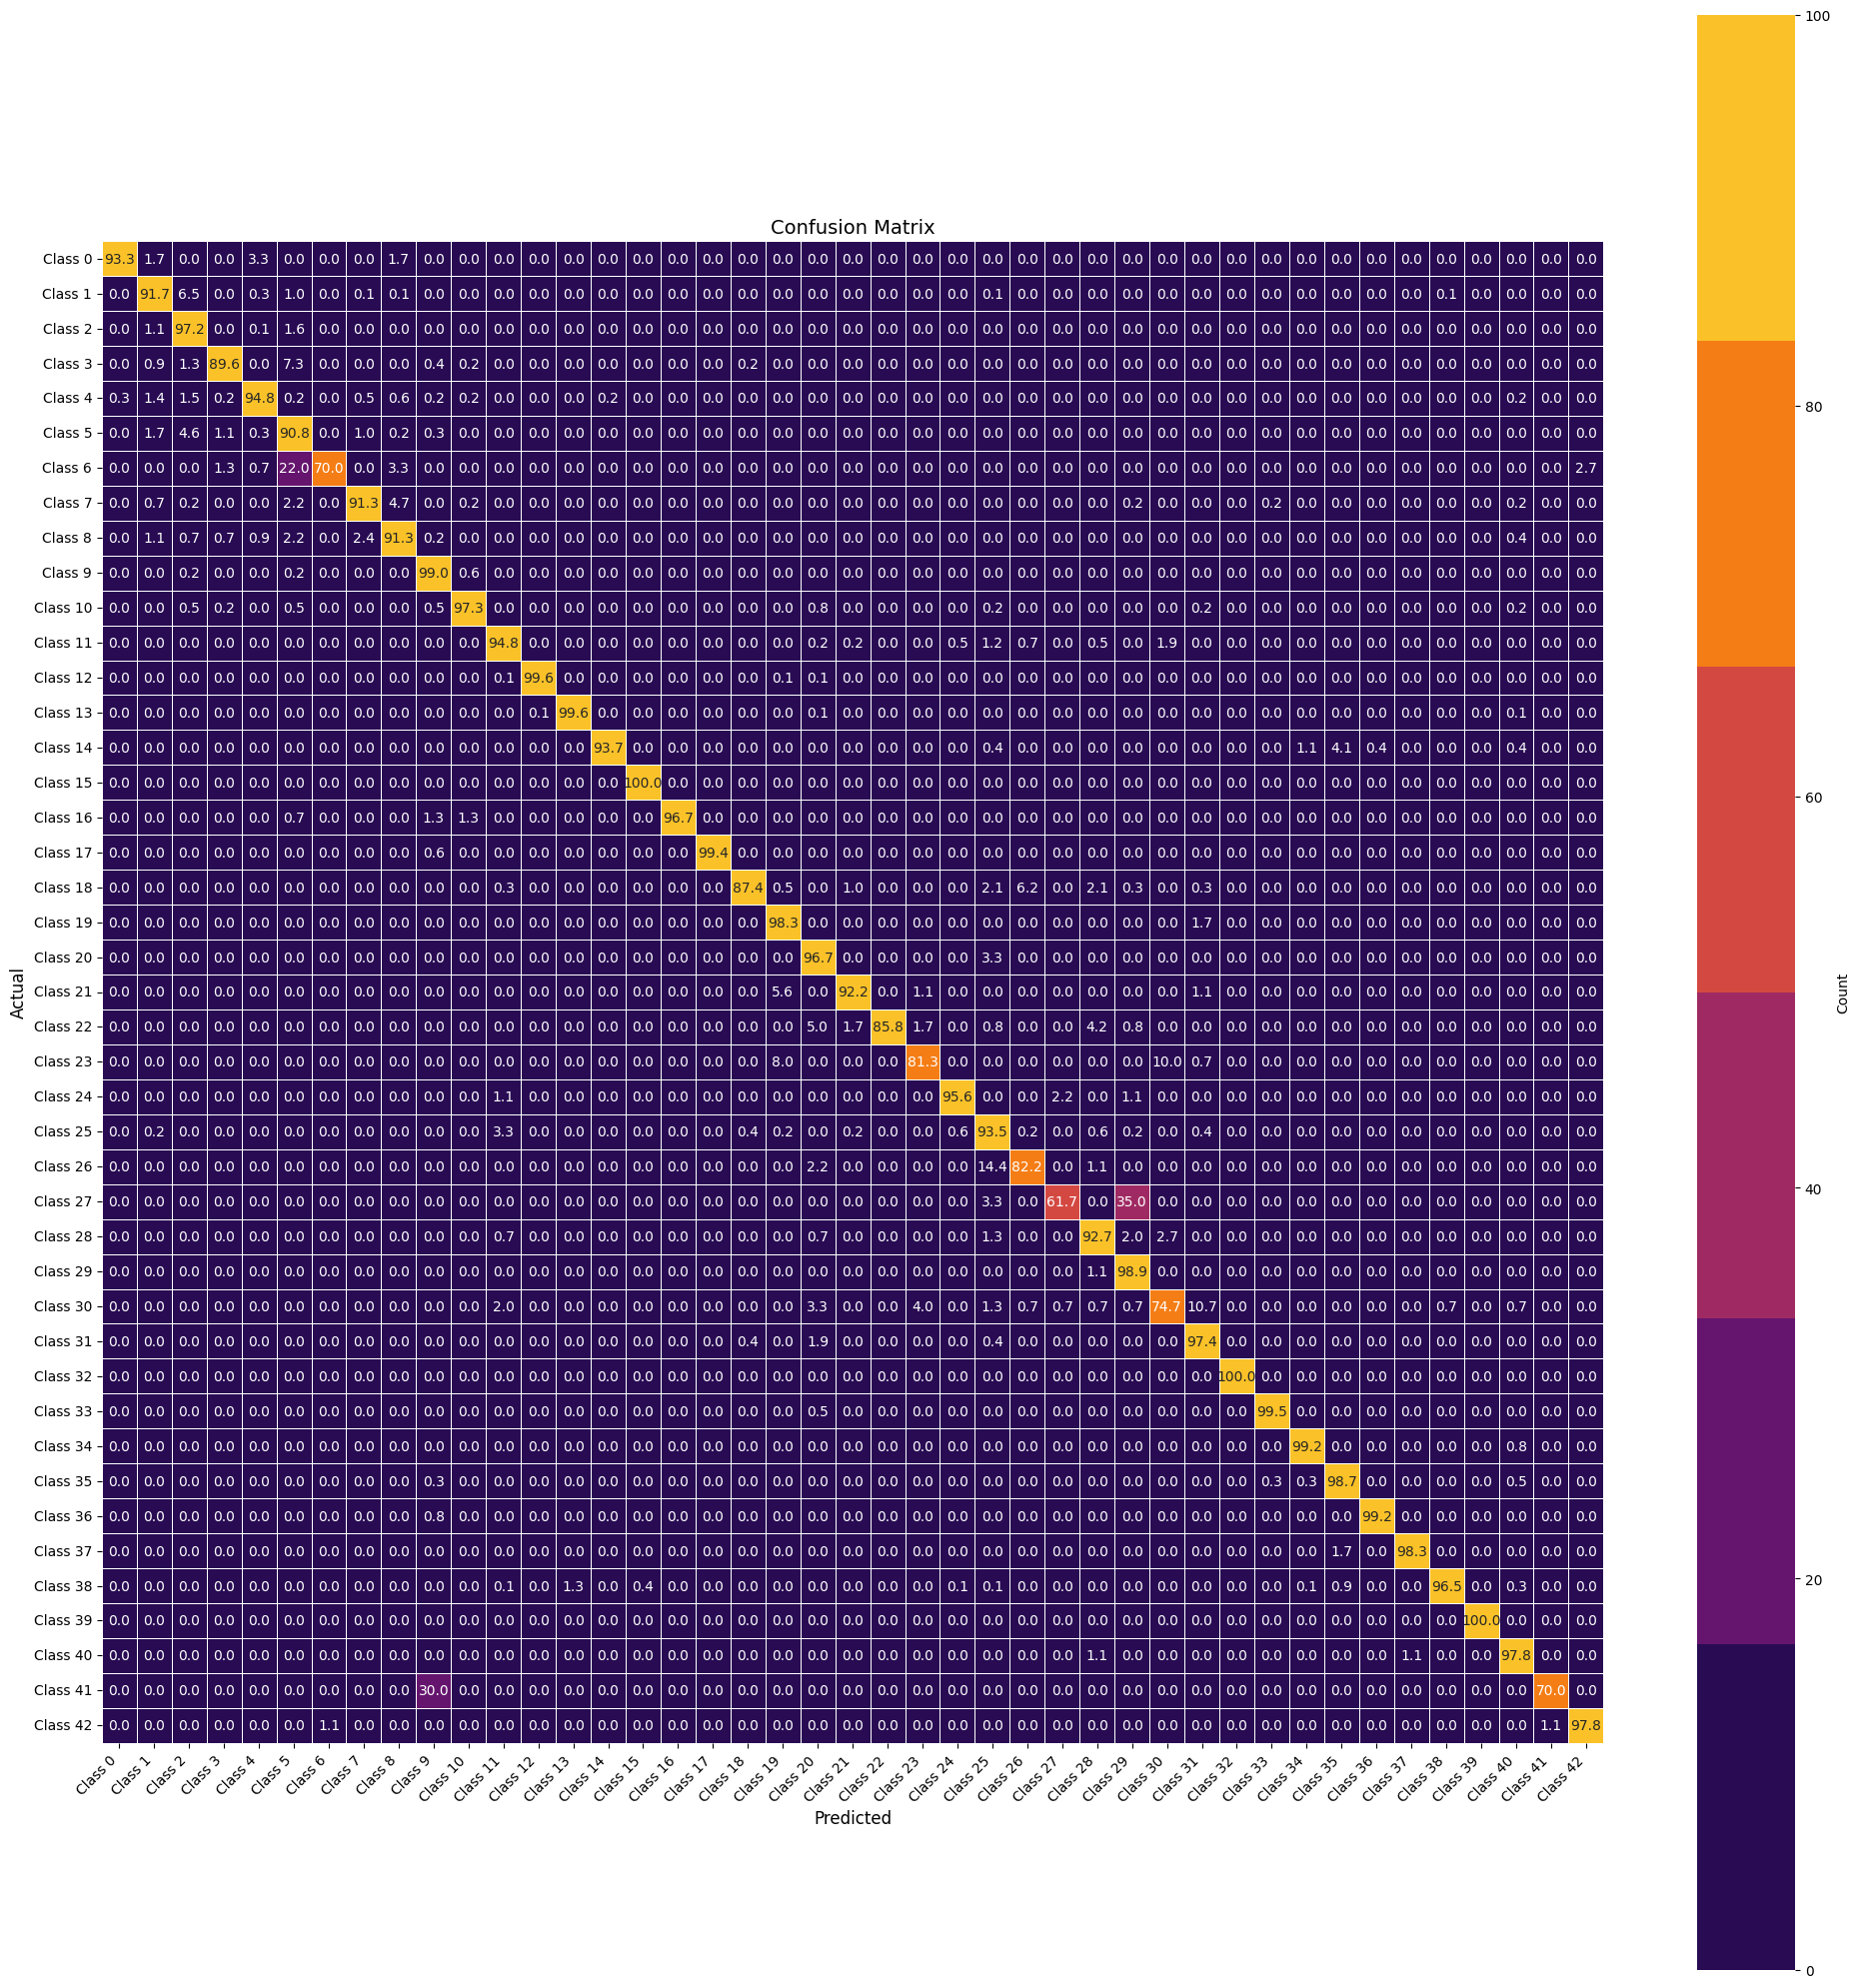

In [17]:
# Create a heatmap for the confusion matrix
plt.figure(figsize=(12, 10))

class_labels = [f"Class {i}" for i in range(43)]


# Create a color map to represent the count values
color_map = ListedColormap(sns.color_palette("inferno"))
plt.figure(figsize=(20, 20))
sns.heatmap(
    cm_percent,
    annot=True,
    fmt=".1f",
    cmap=color_map,
    linewidths=0.5,
    square=True,
    cbar_kws={"label": "Count"},
    xticklabels=class_labels,
    yticklabels=class_labels,
    annot_kws={"size": 10},
)

# Customize labels and title
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Adjust layout to prevent cutoff of labels
plt.tight_layout()

# Show the plot
plt.show()

In [19]:
report = classification_report(y_test, y_pred)


def display_classification_report(report):
    report_html = HTML(f"<pre>{report}</pre>")
    display(report_html)


# Display the formatted classification report
display_classification_report(report)

In [29]:
num_classes_confused = 10  # Change this to display more or less classes
flat_cm_percentage = cm_percent.flatten()
# Filter out cases where row index equals column index
non_equal_indices = np.where(
    np.arange(flat_cm_percentage.size) // cm_percent.shape[1]
    != np.arange(flat_cm_percentage.size) % cm_percent.shape[1]
)

# Get the indices of the top 4 most confused items excluding equal indices
top_confused_indices = np.argsort(flat_cm_percentage[non_equal_indices])[::-1][
    :num_classes_confused
]

# Reshape the indices to get corresponding row and column indices
row_indices, col_indices = np.unravel_index(
    non_equal_indices[0][top_confused_indices], cm_percent.shape
)

# Display the top 4 most confused items
top_confused_items = list(
    zip(
        row_indices,
        col_indices,
        flat_cm_percentage[non_equal_indices][top_confused_indices],
    )
)
print(f"\tTop {num_classes_confused} Most Confused Classes:")
print(45*'-')
for row, col, percentage in top_confused_items:
    print(f"True Class: {row:2d}\tPredicted Class {col:2d}:   {percentage:5.2f}%")

	Top 10 Most Confused Classes:
---------------------------------------------
True Class: 27	Predicted Class 29:   35.00%
True Class: 41	Predicted Class  9:   30.00%
True Class:  6	Predicted Class  5:   22.00%
True Class: 26	Predicted Class 25:   14.44%
True Class: 30	Predicted Class 31:   10.67%
True Class: 23	Predicted Class 30:   10.00%
True Class: 23	Predicted Class 19:    8.00%
True Class:  3	Predicted Class  5:    7.33%
True Class:  1	Predicted Class  2:    6.53%
True Class: 18	Predicted Class 26:    6.15%


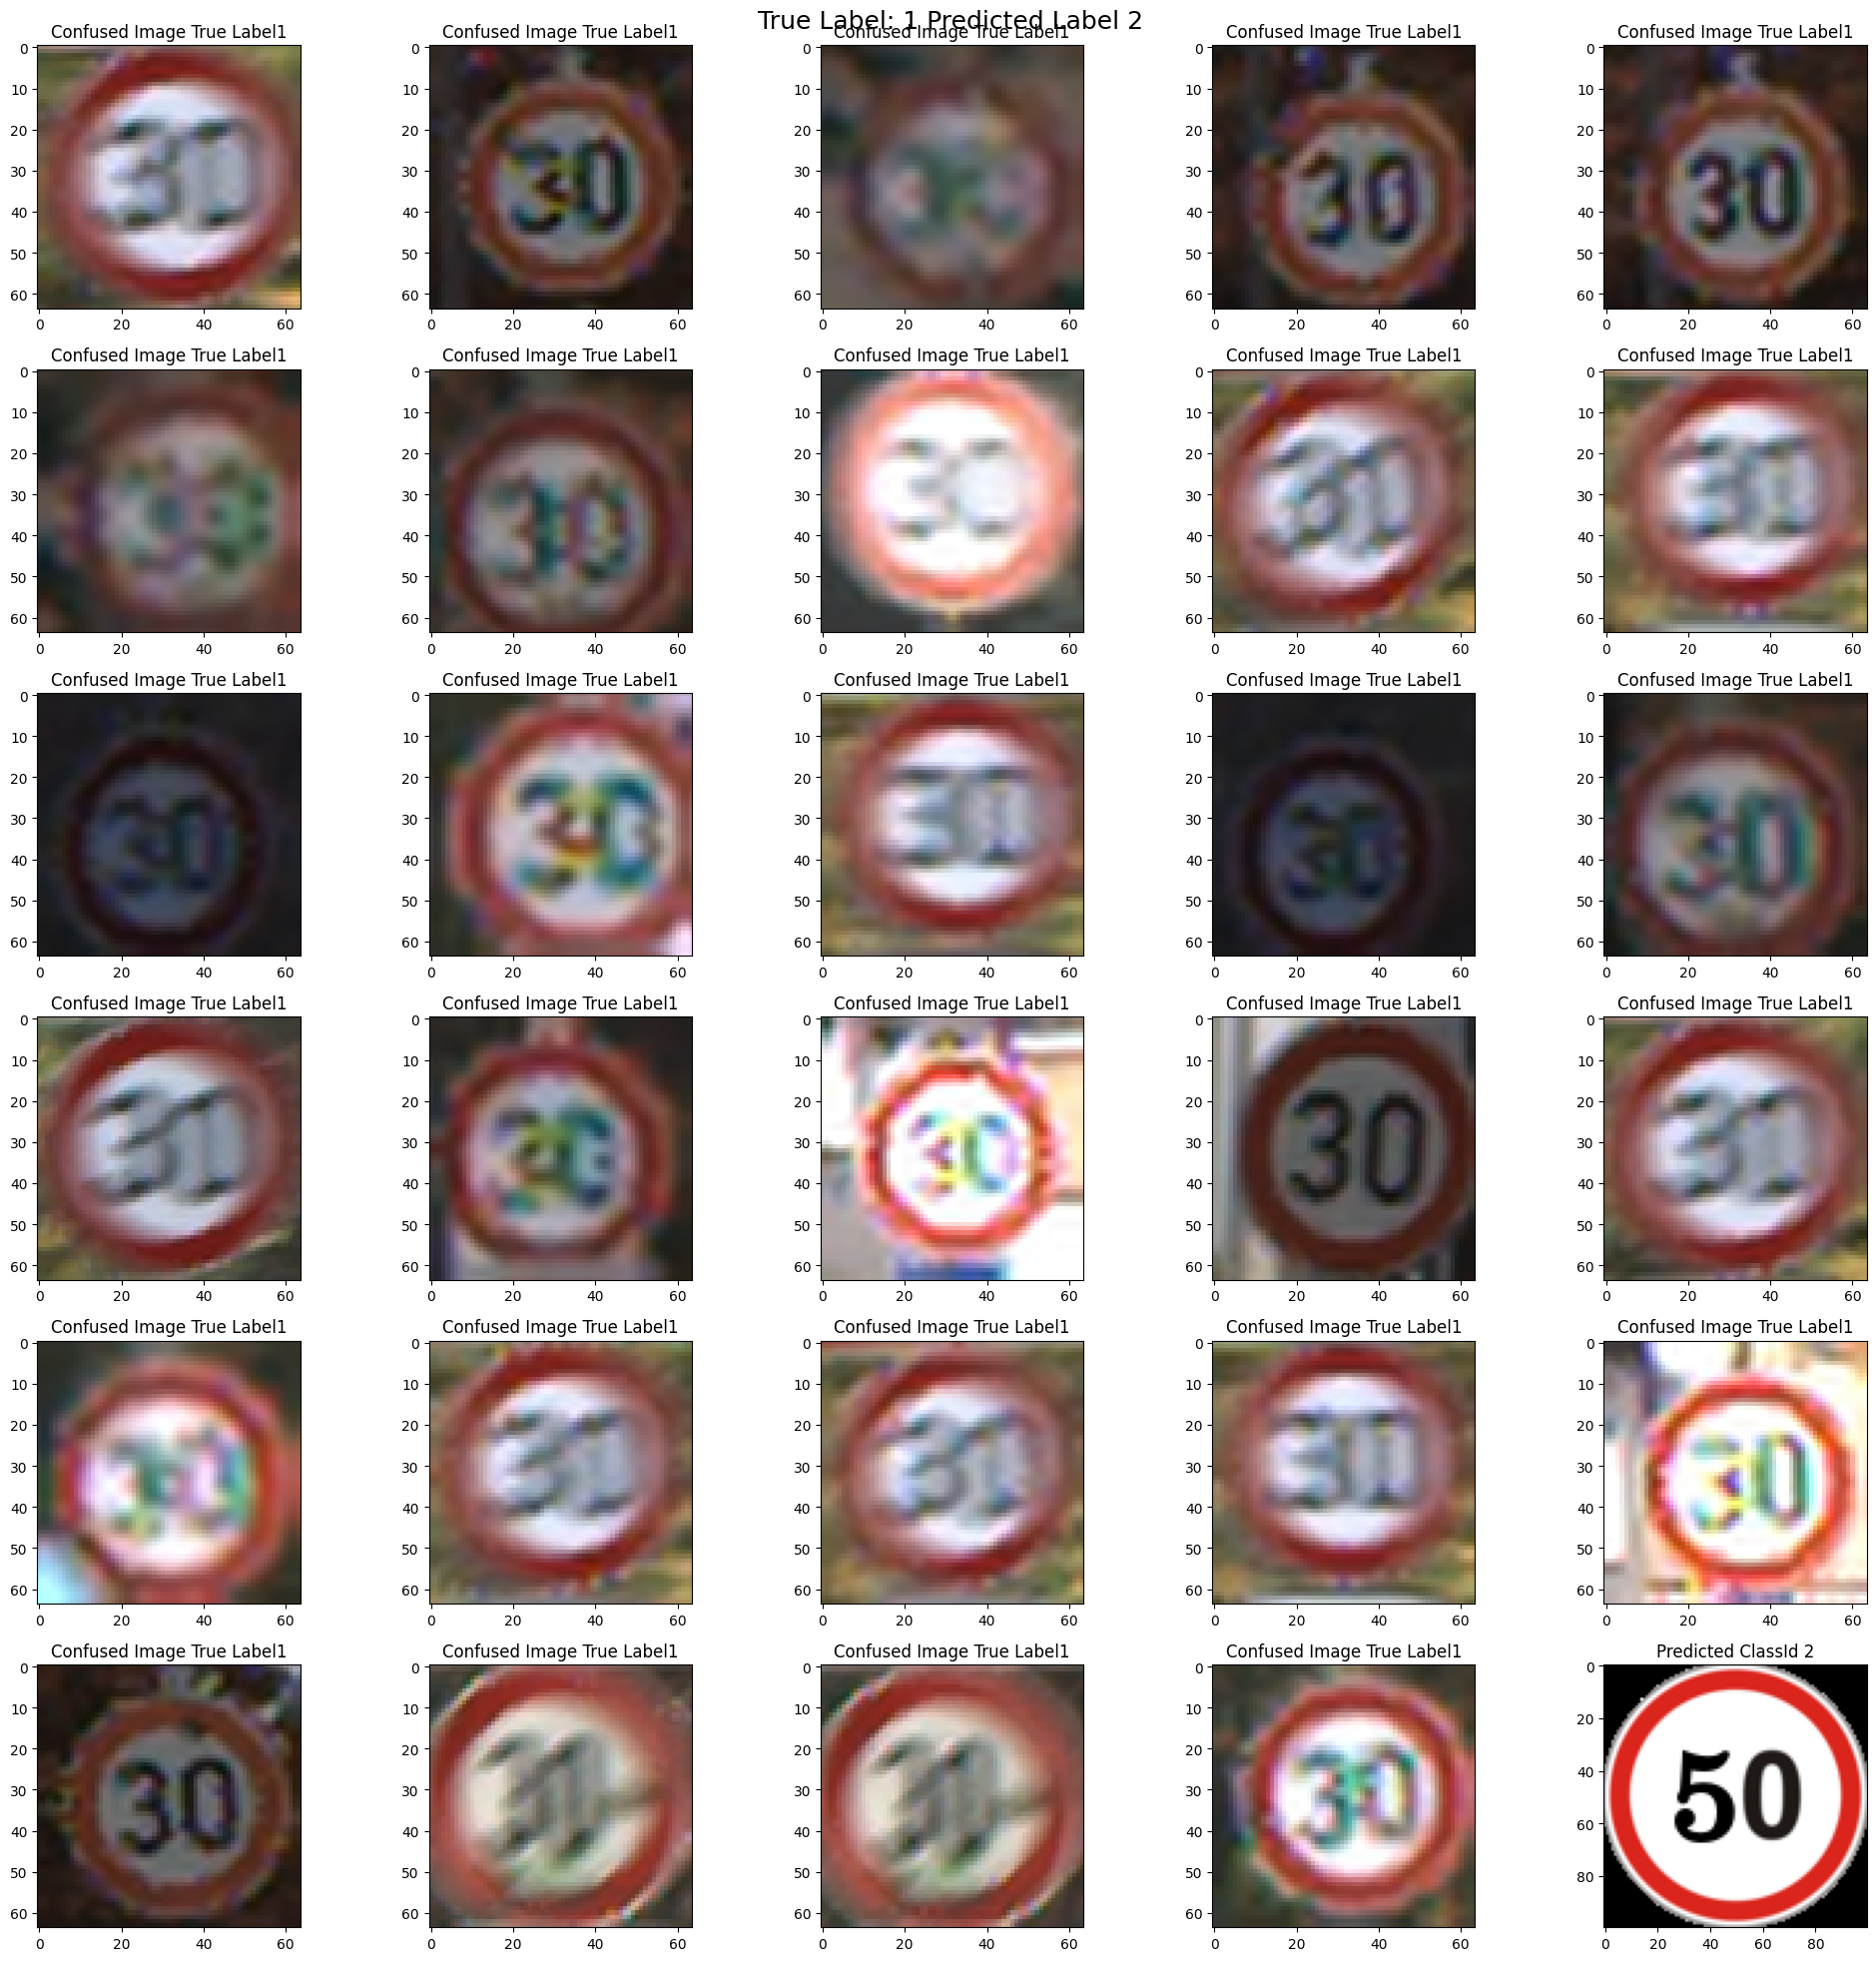

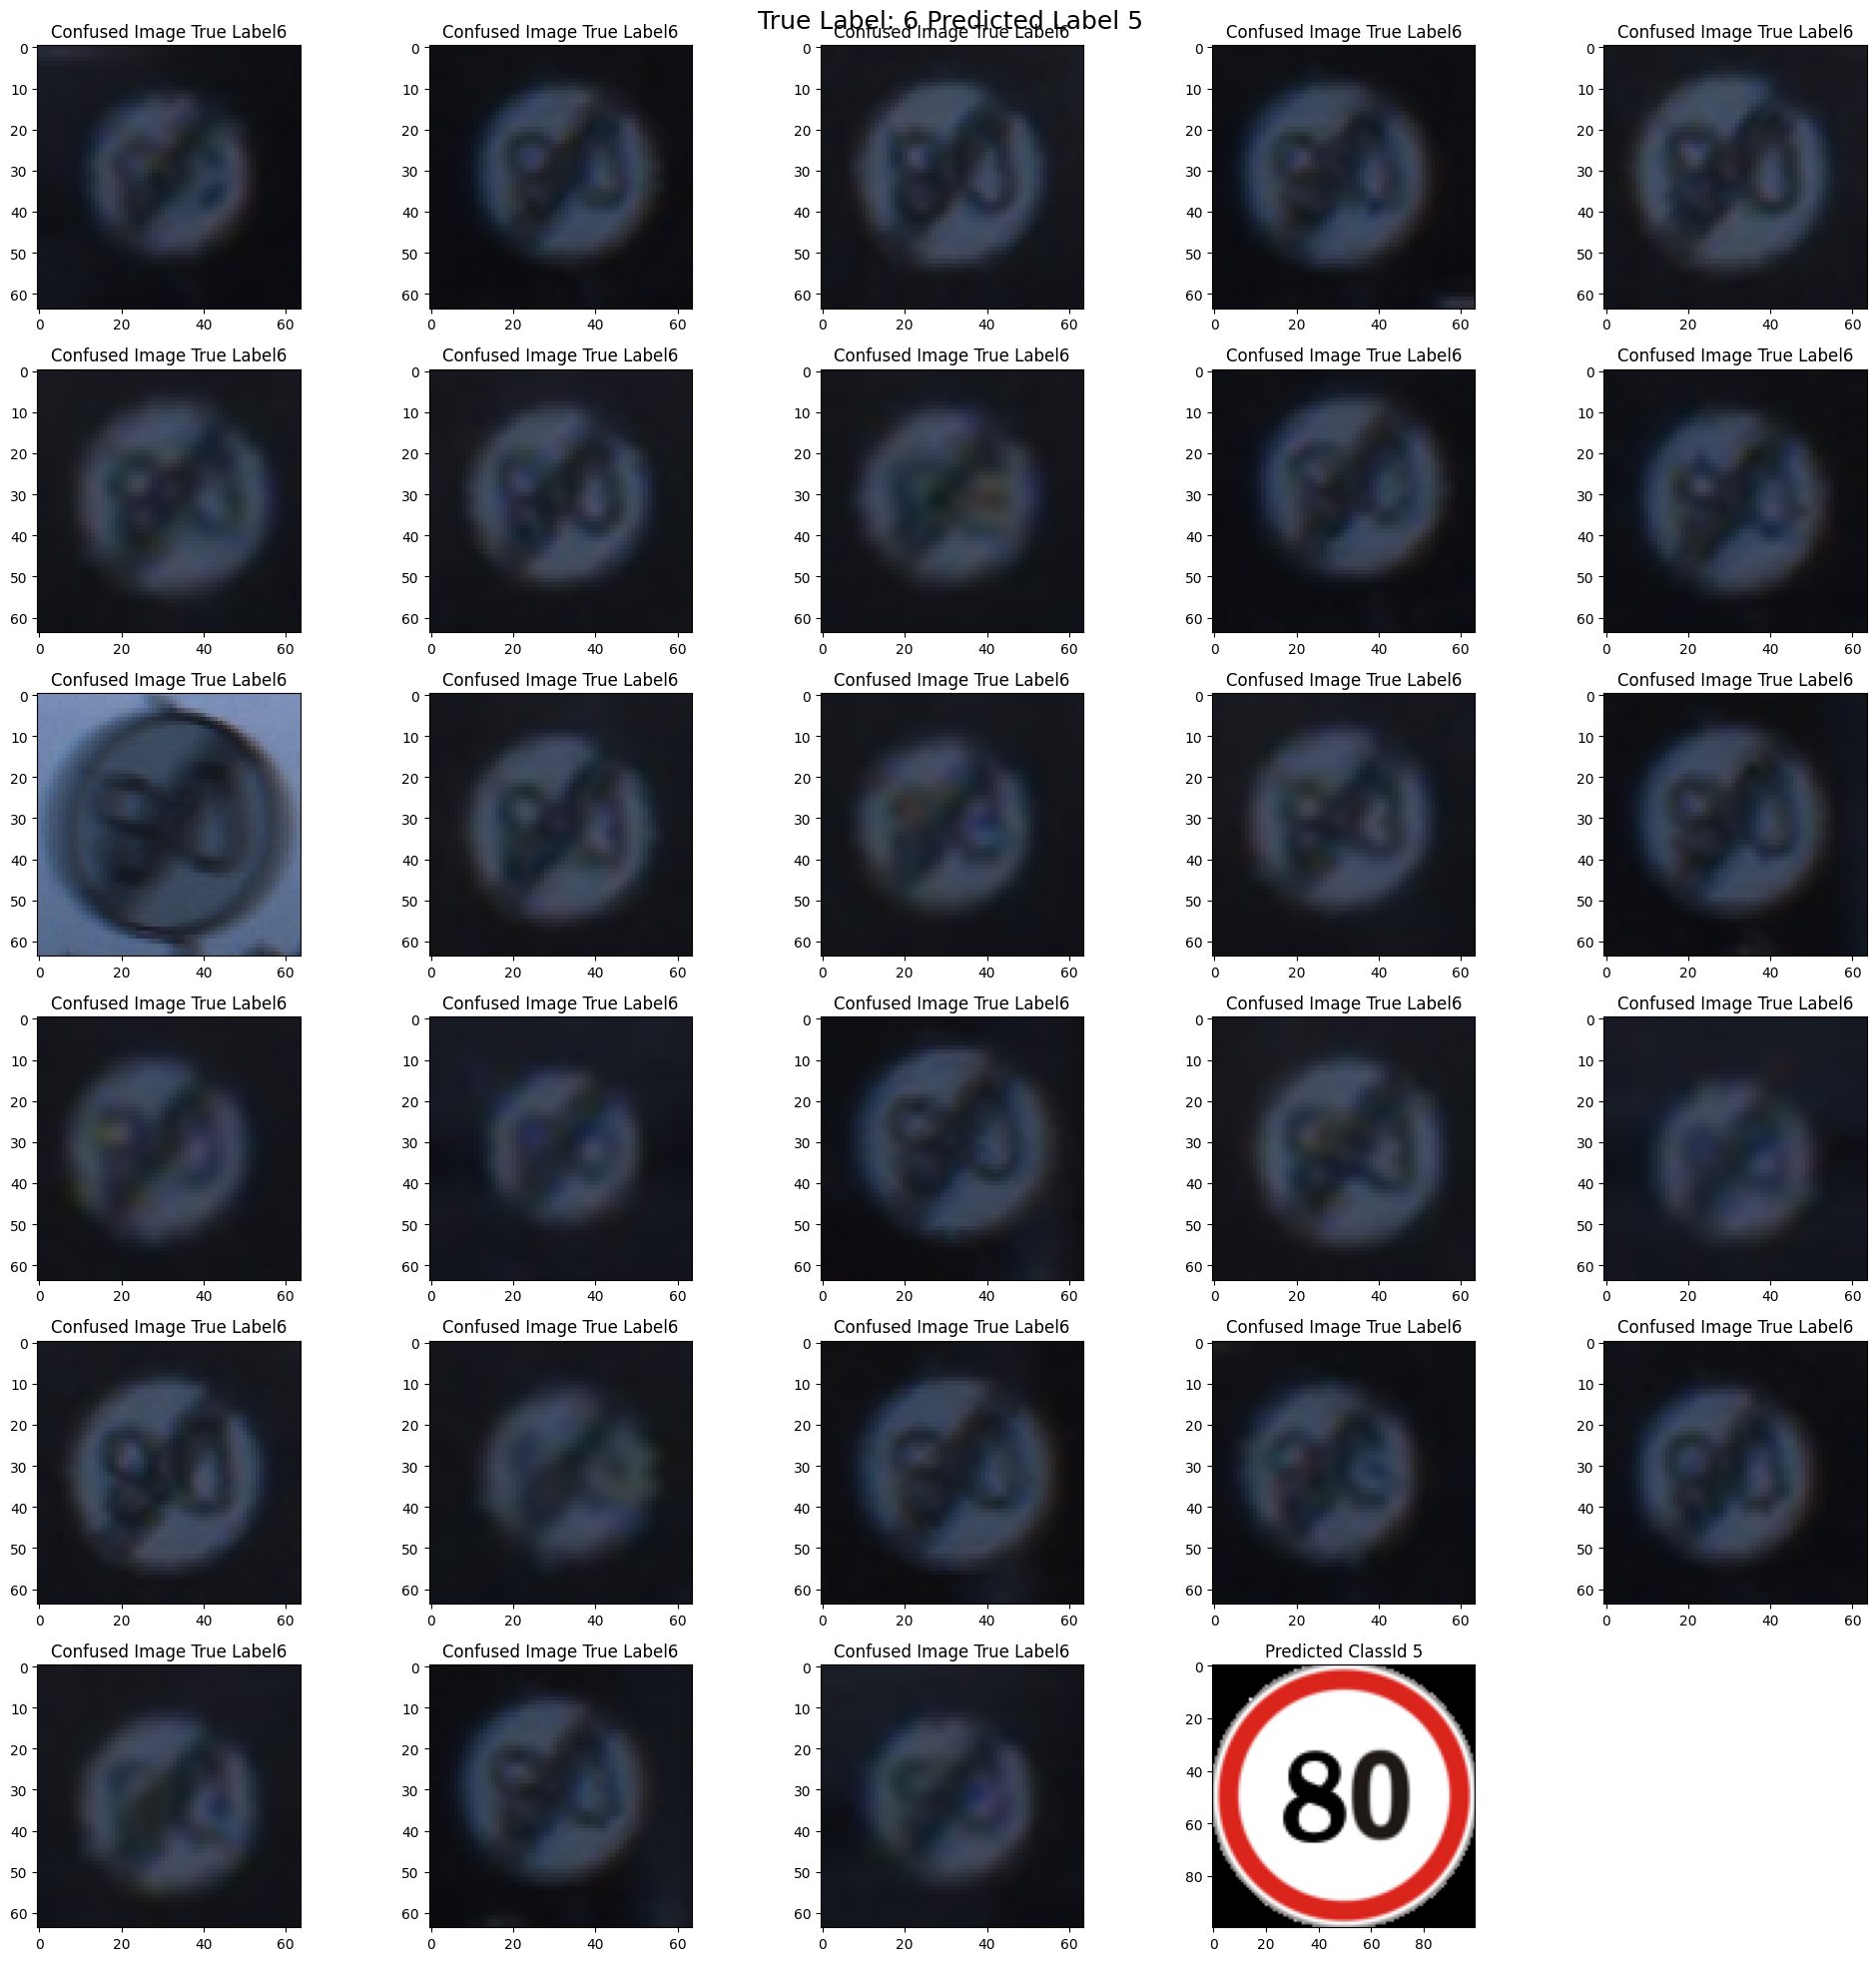

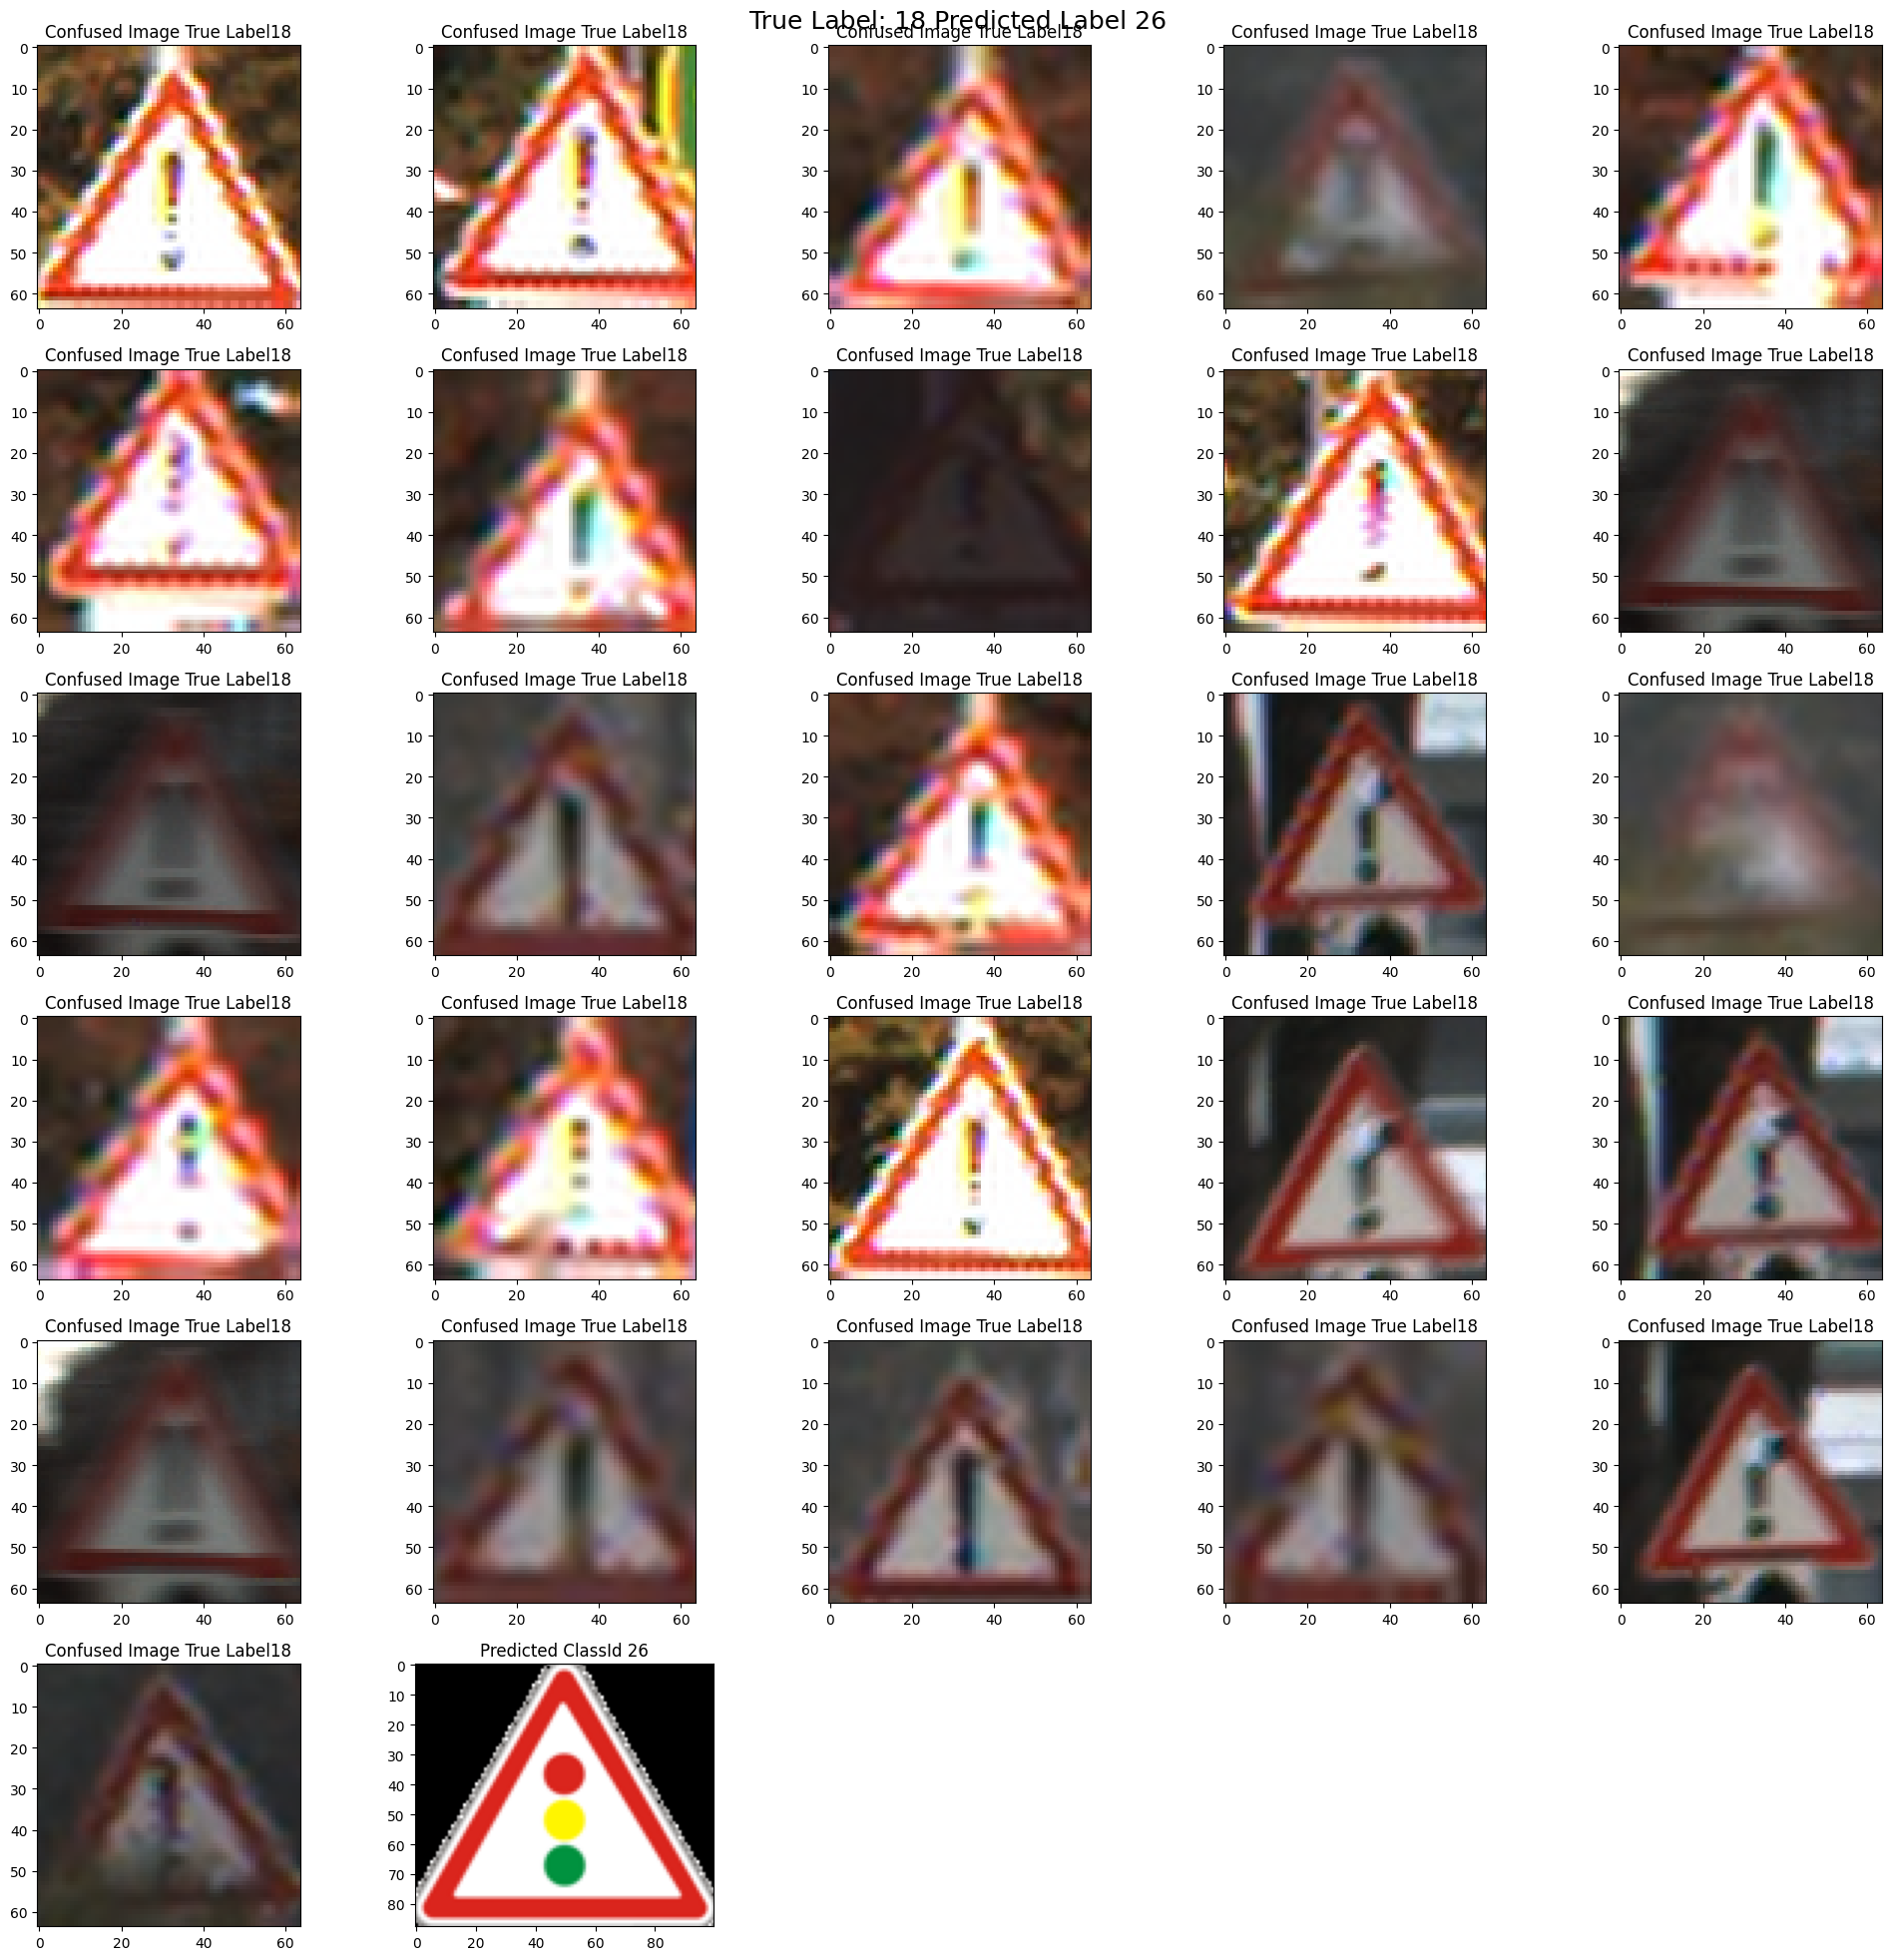

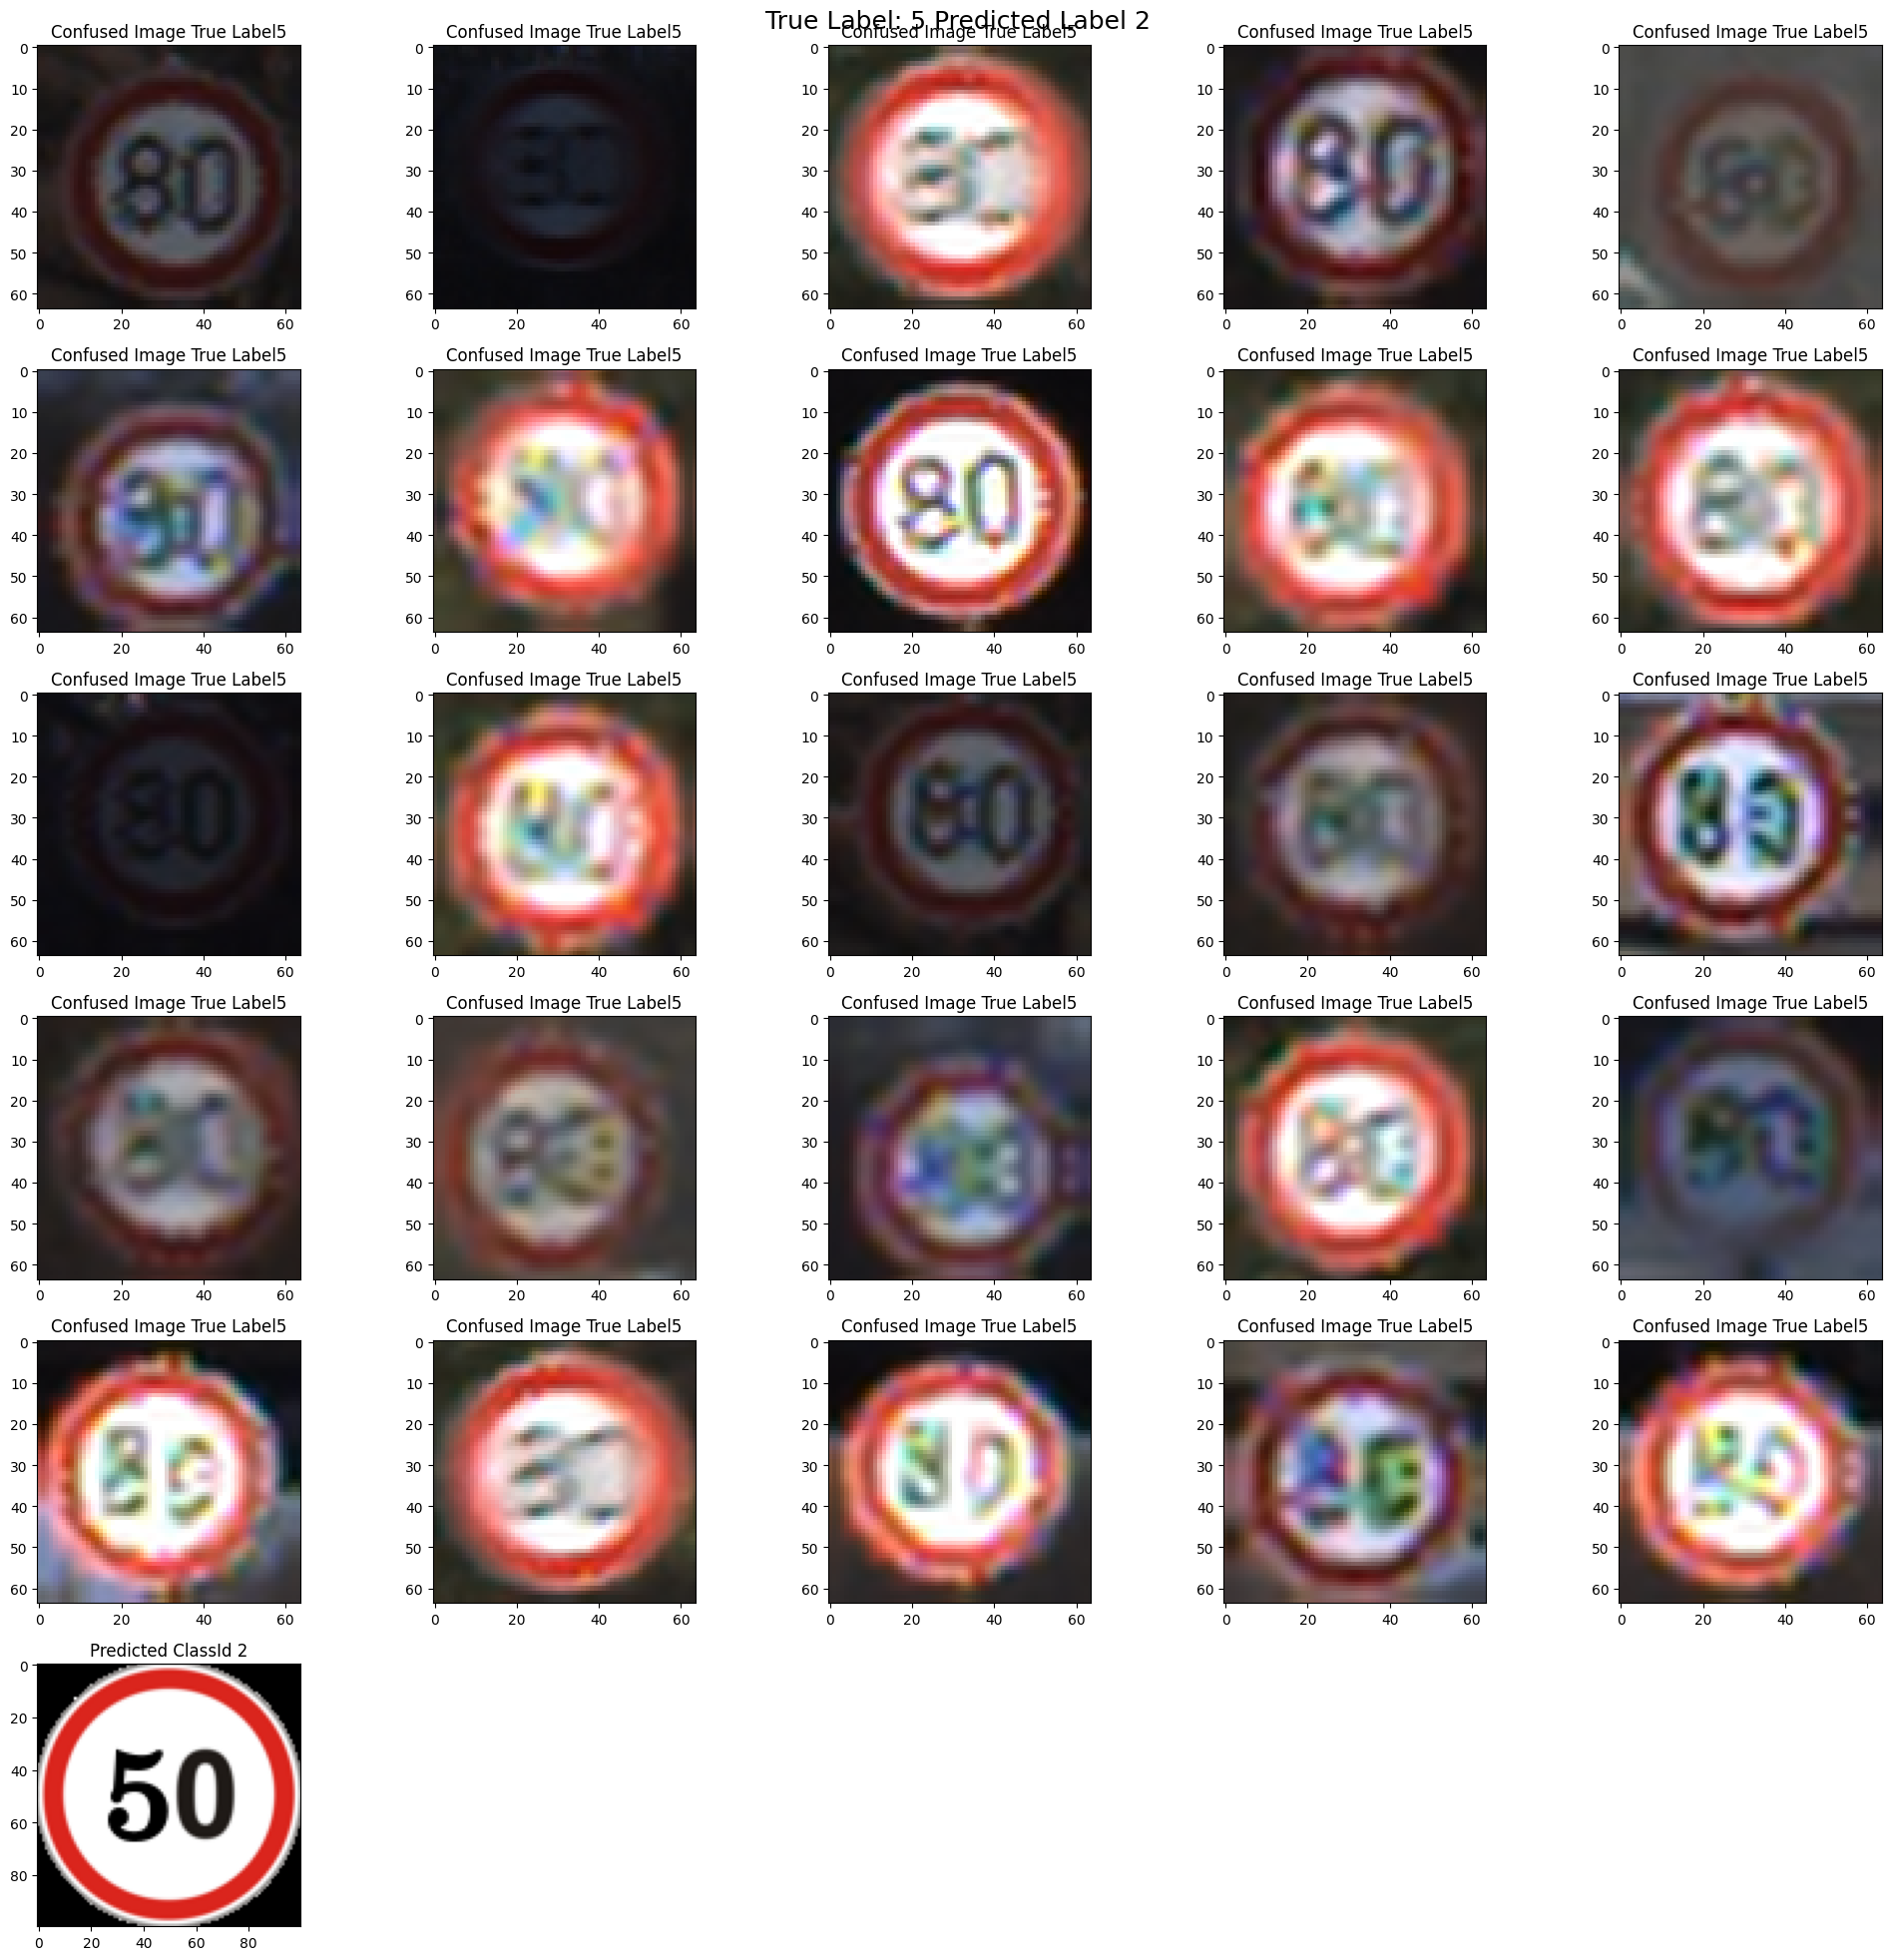

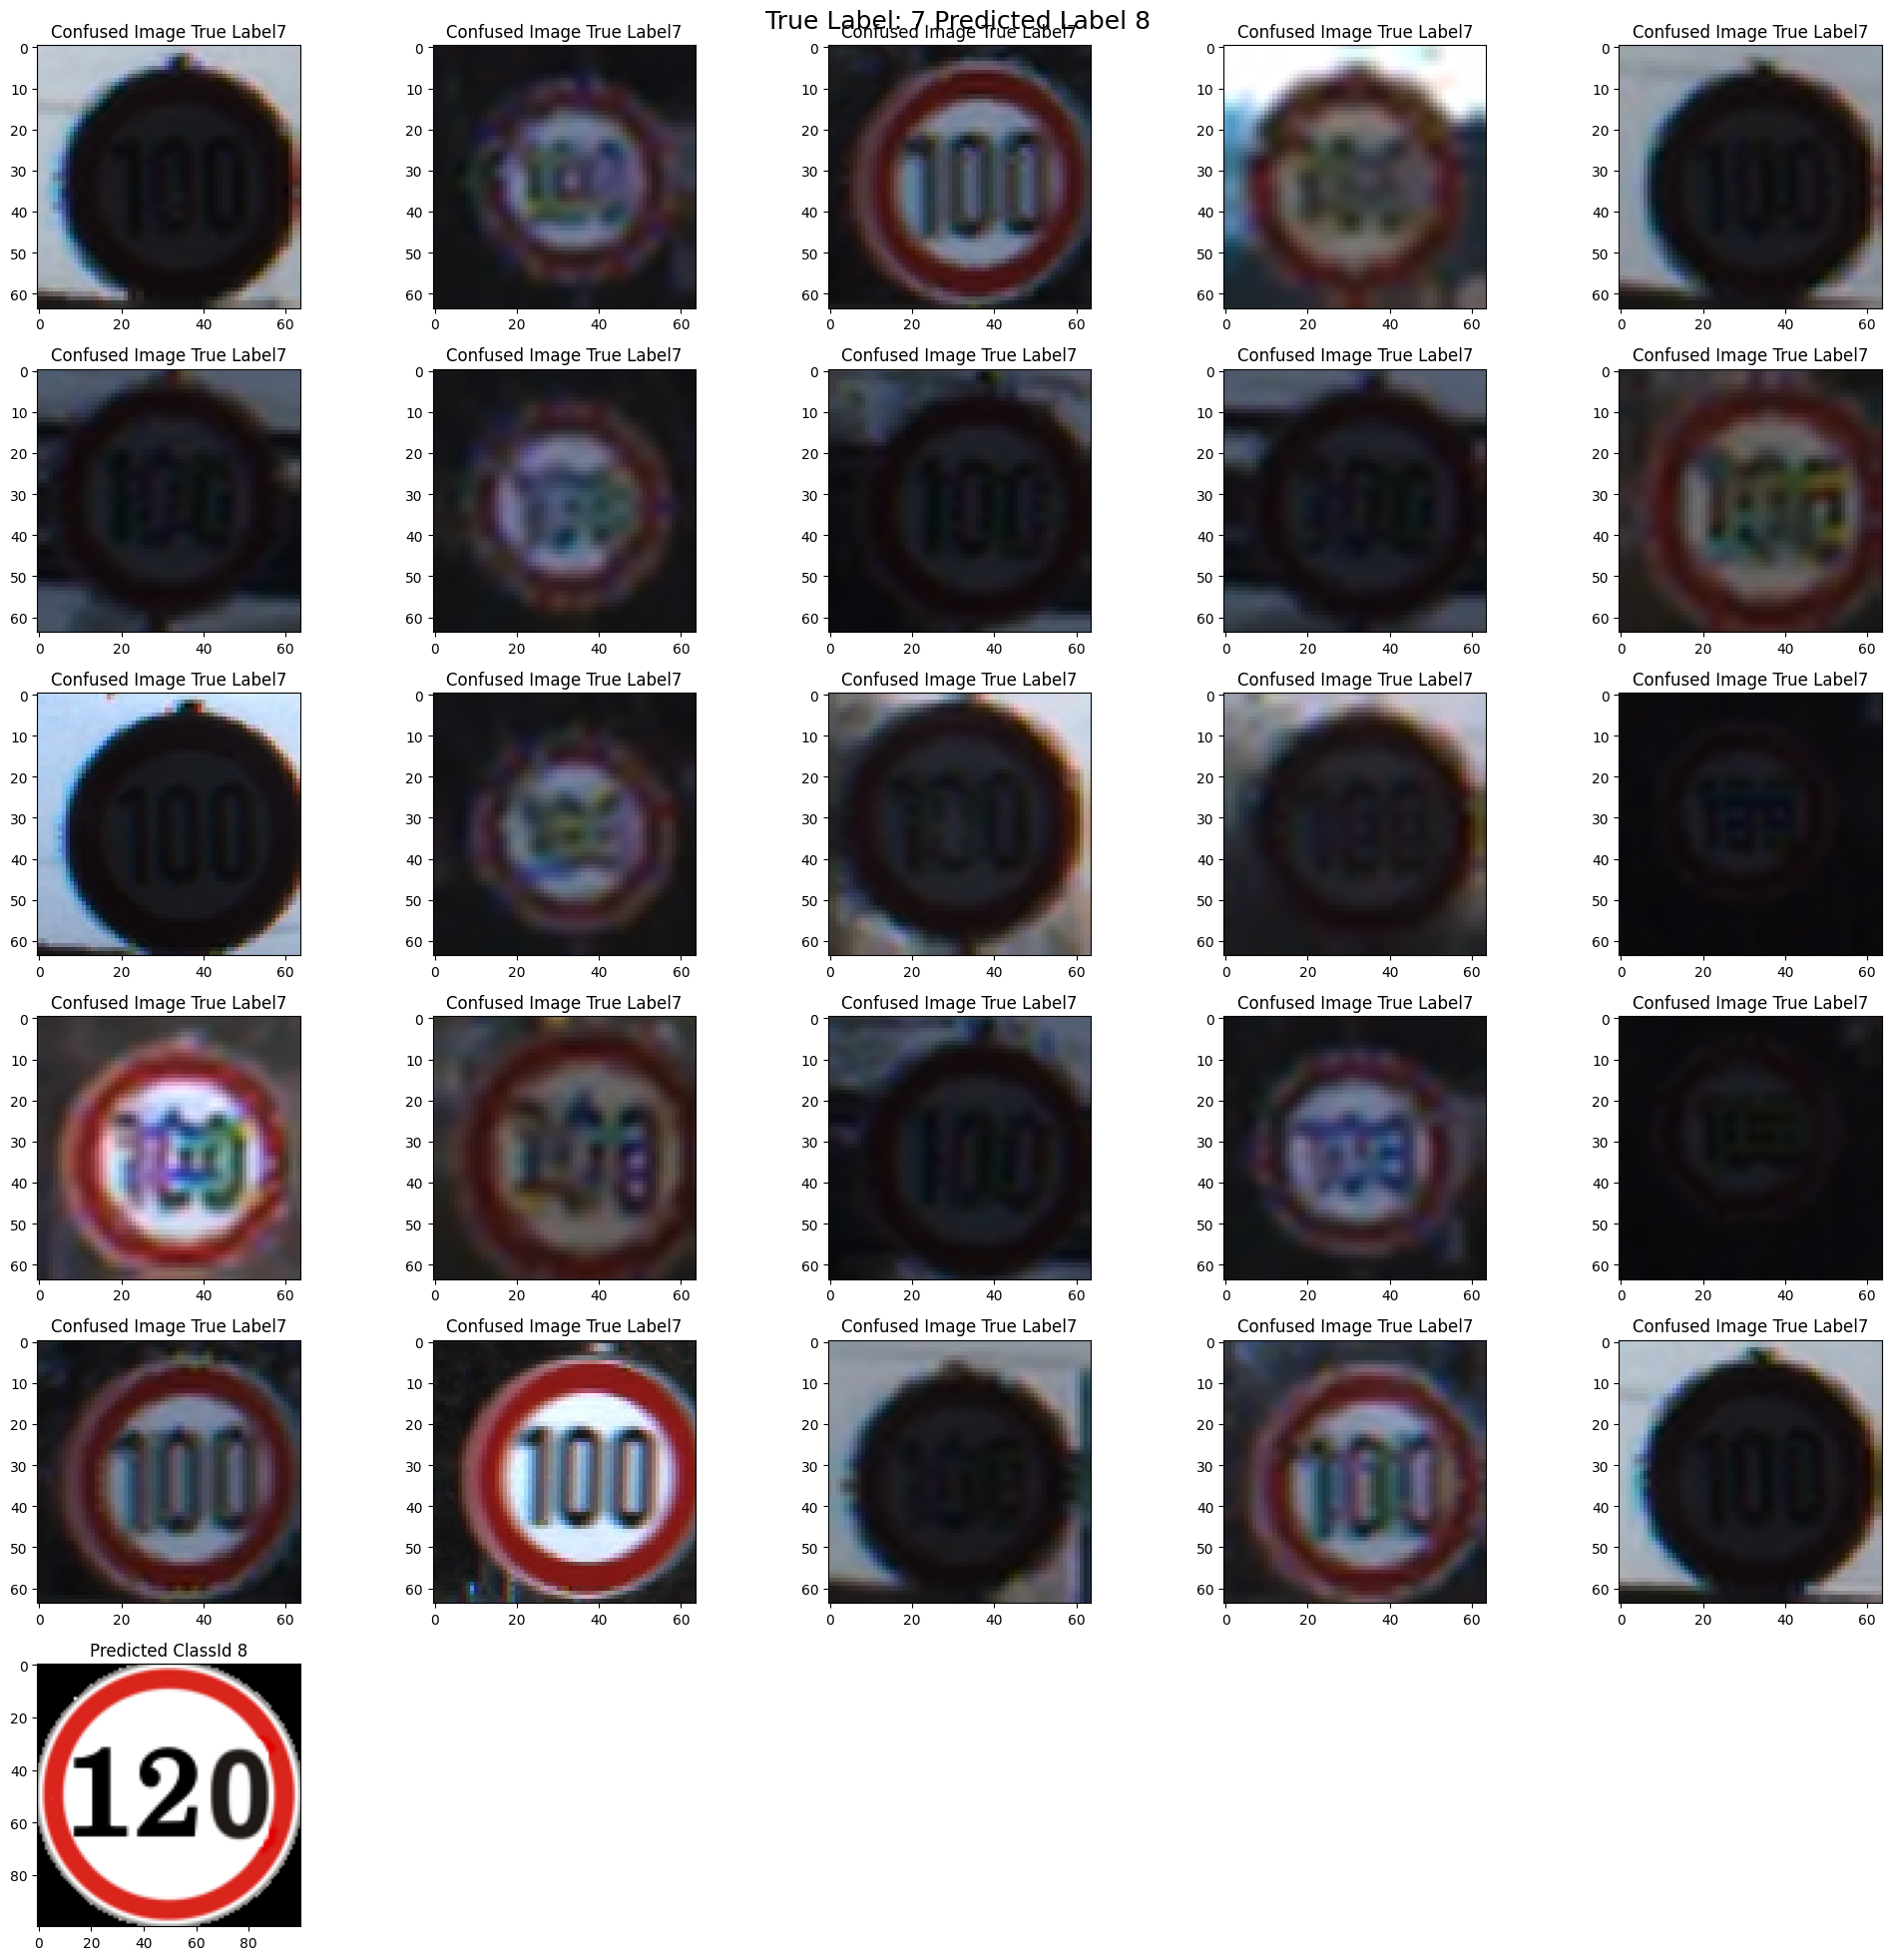

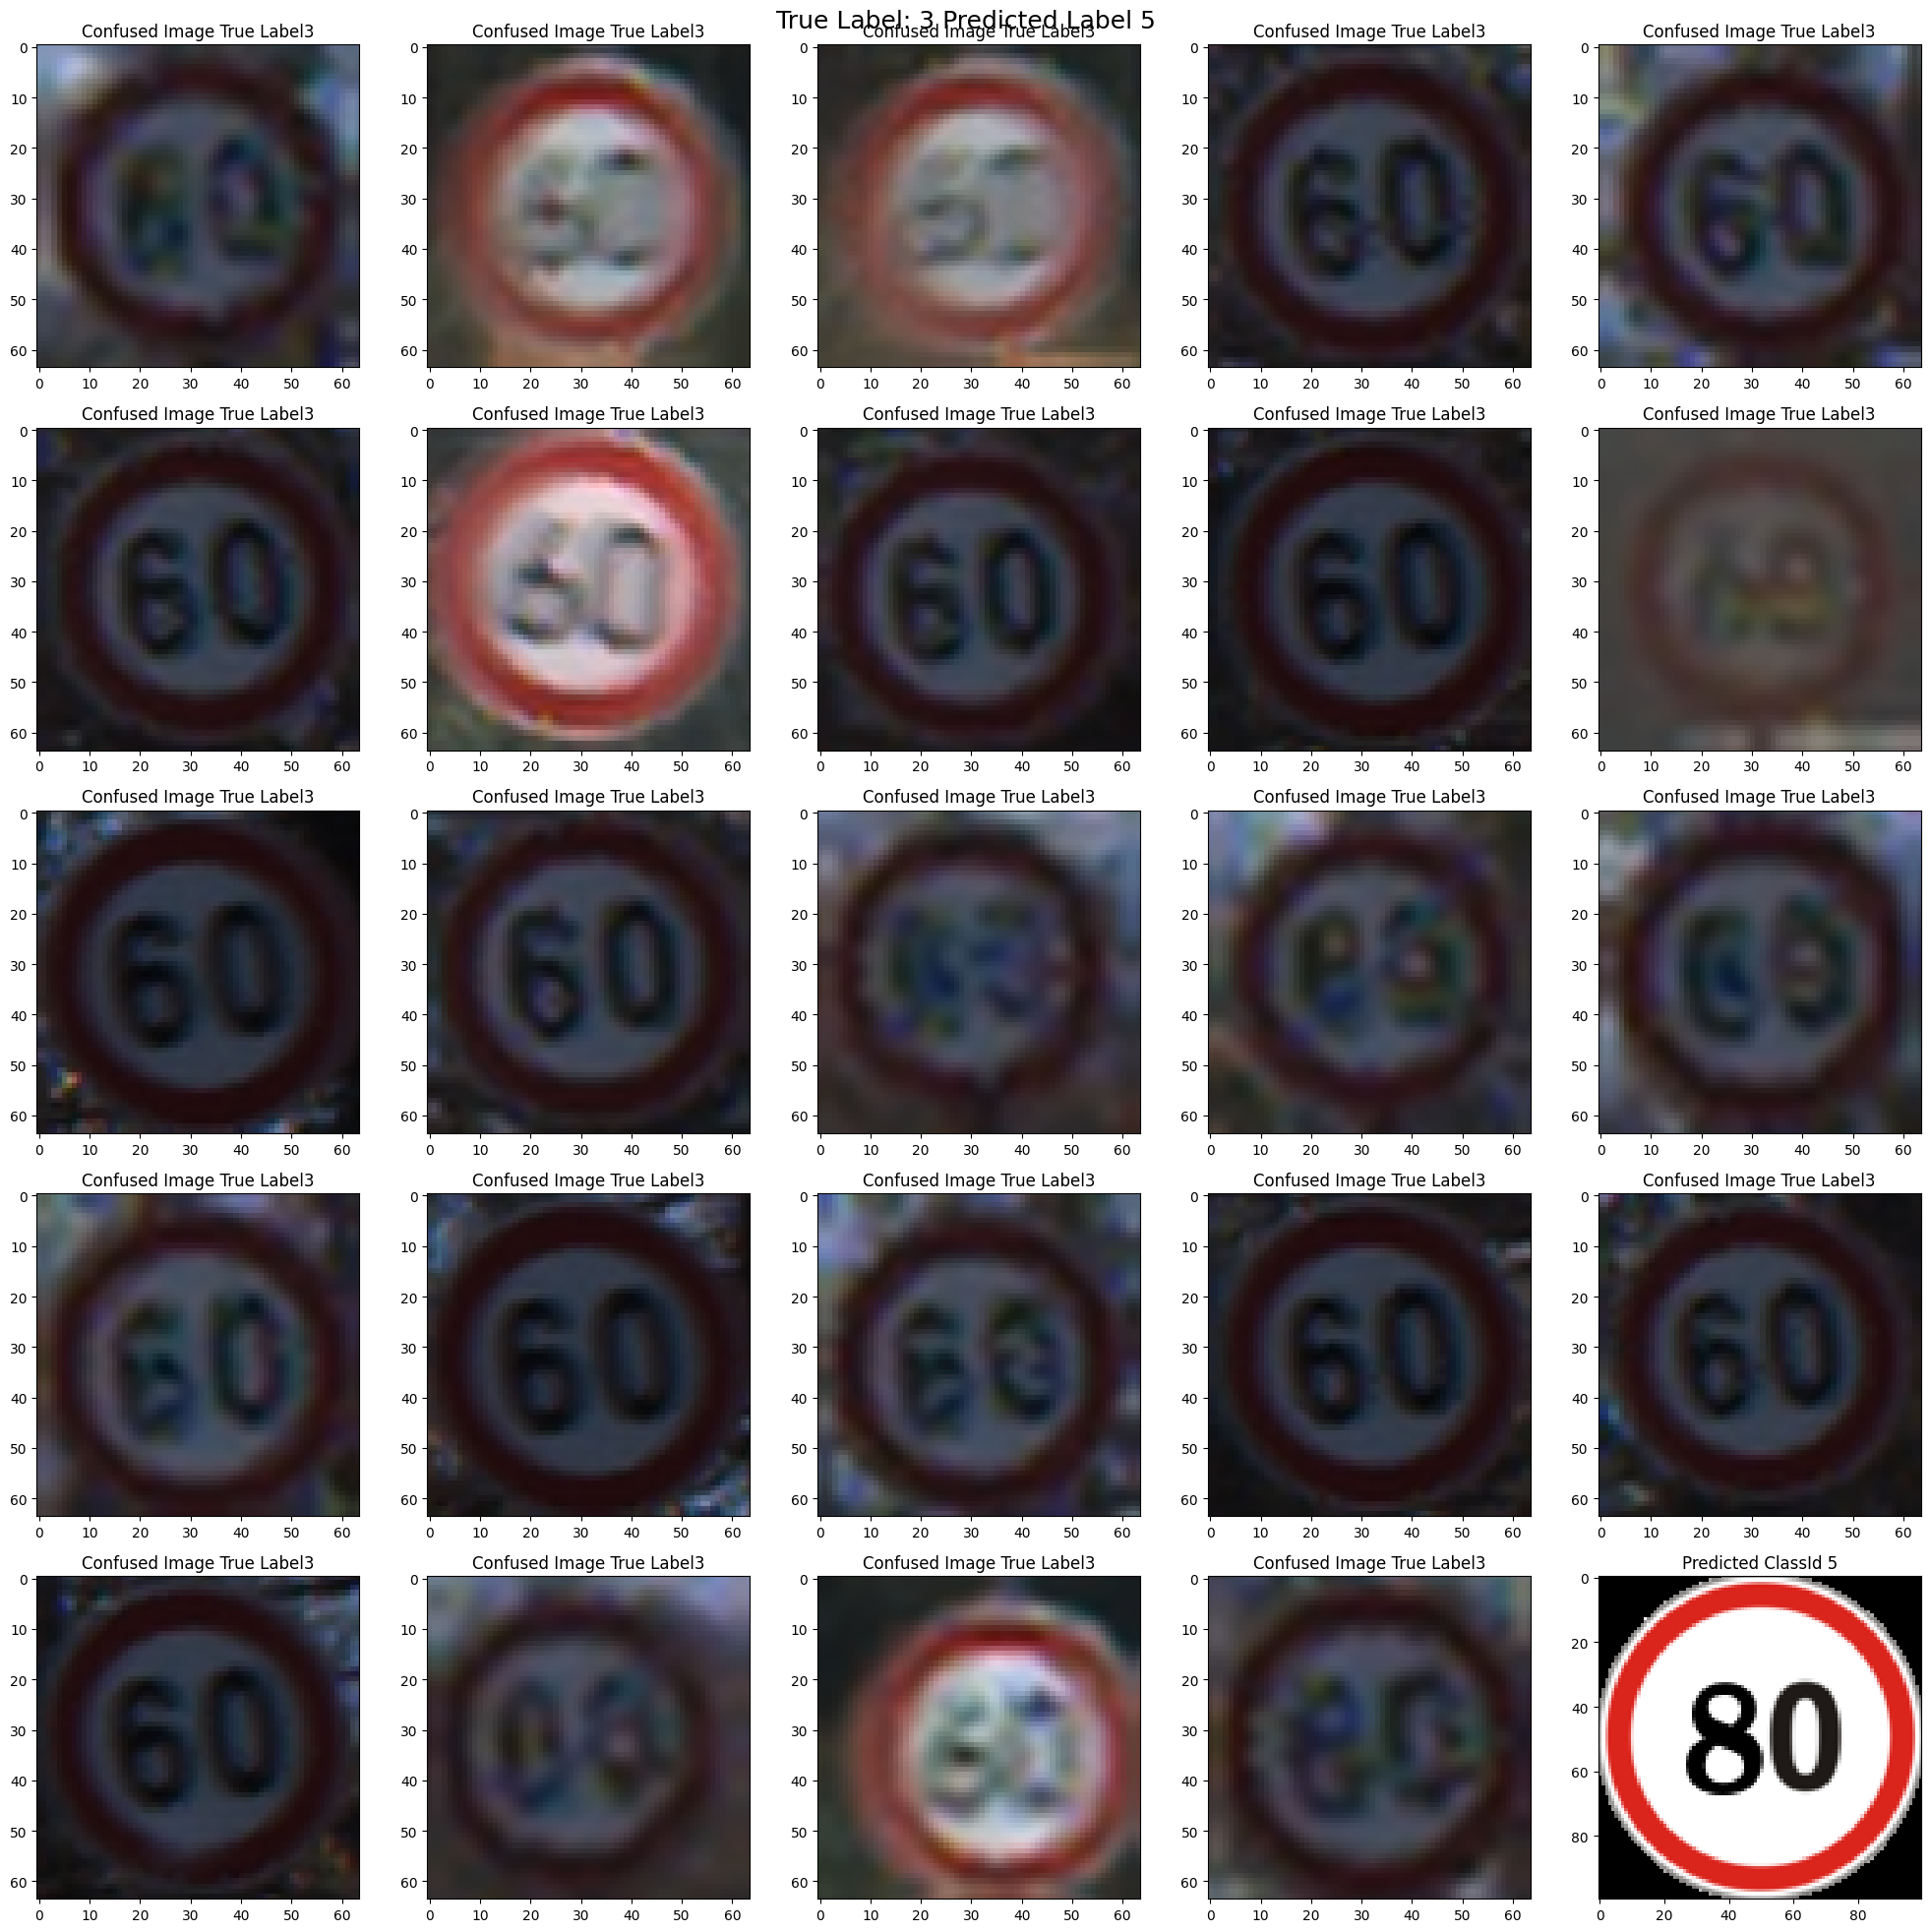

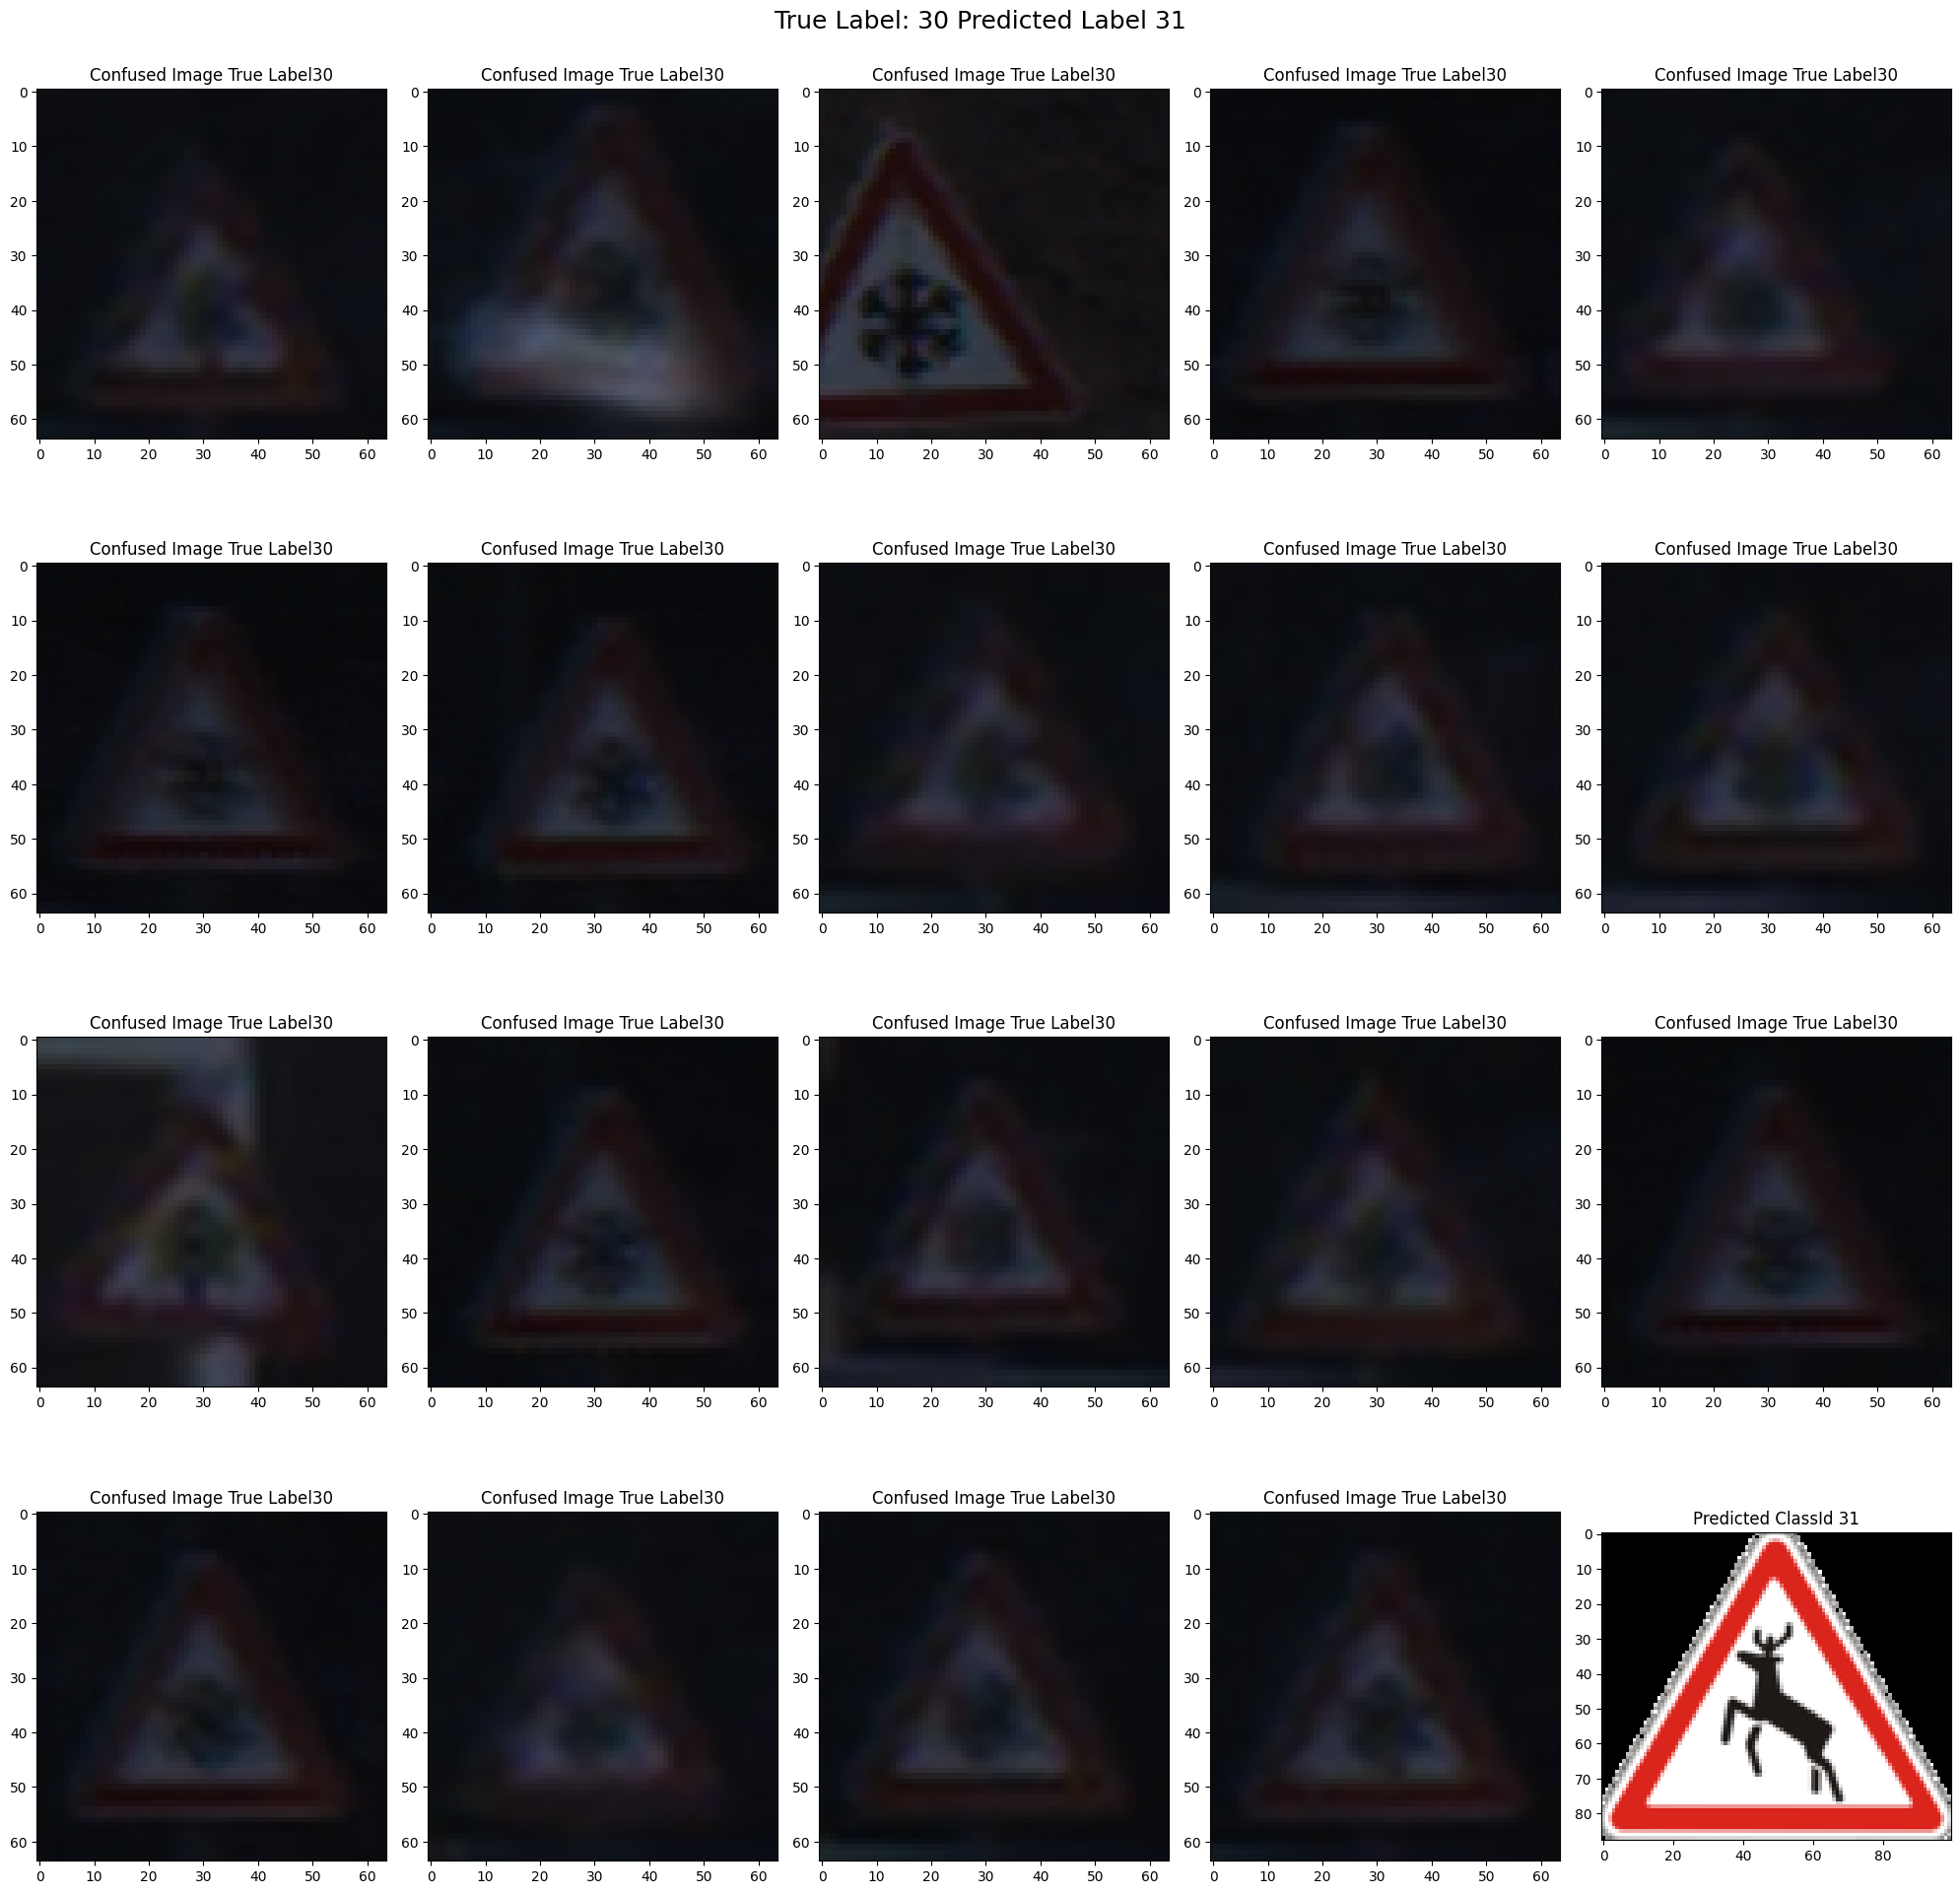

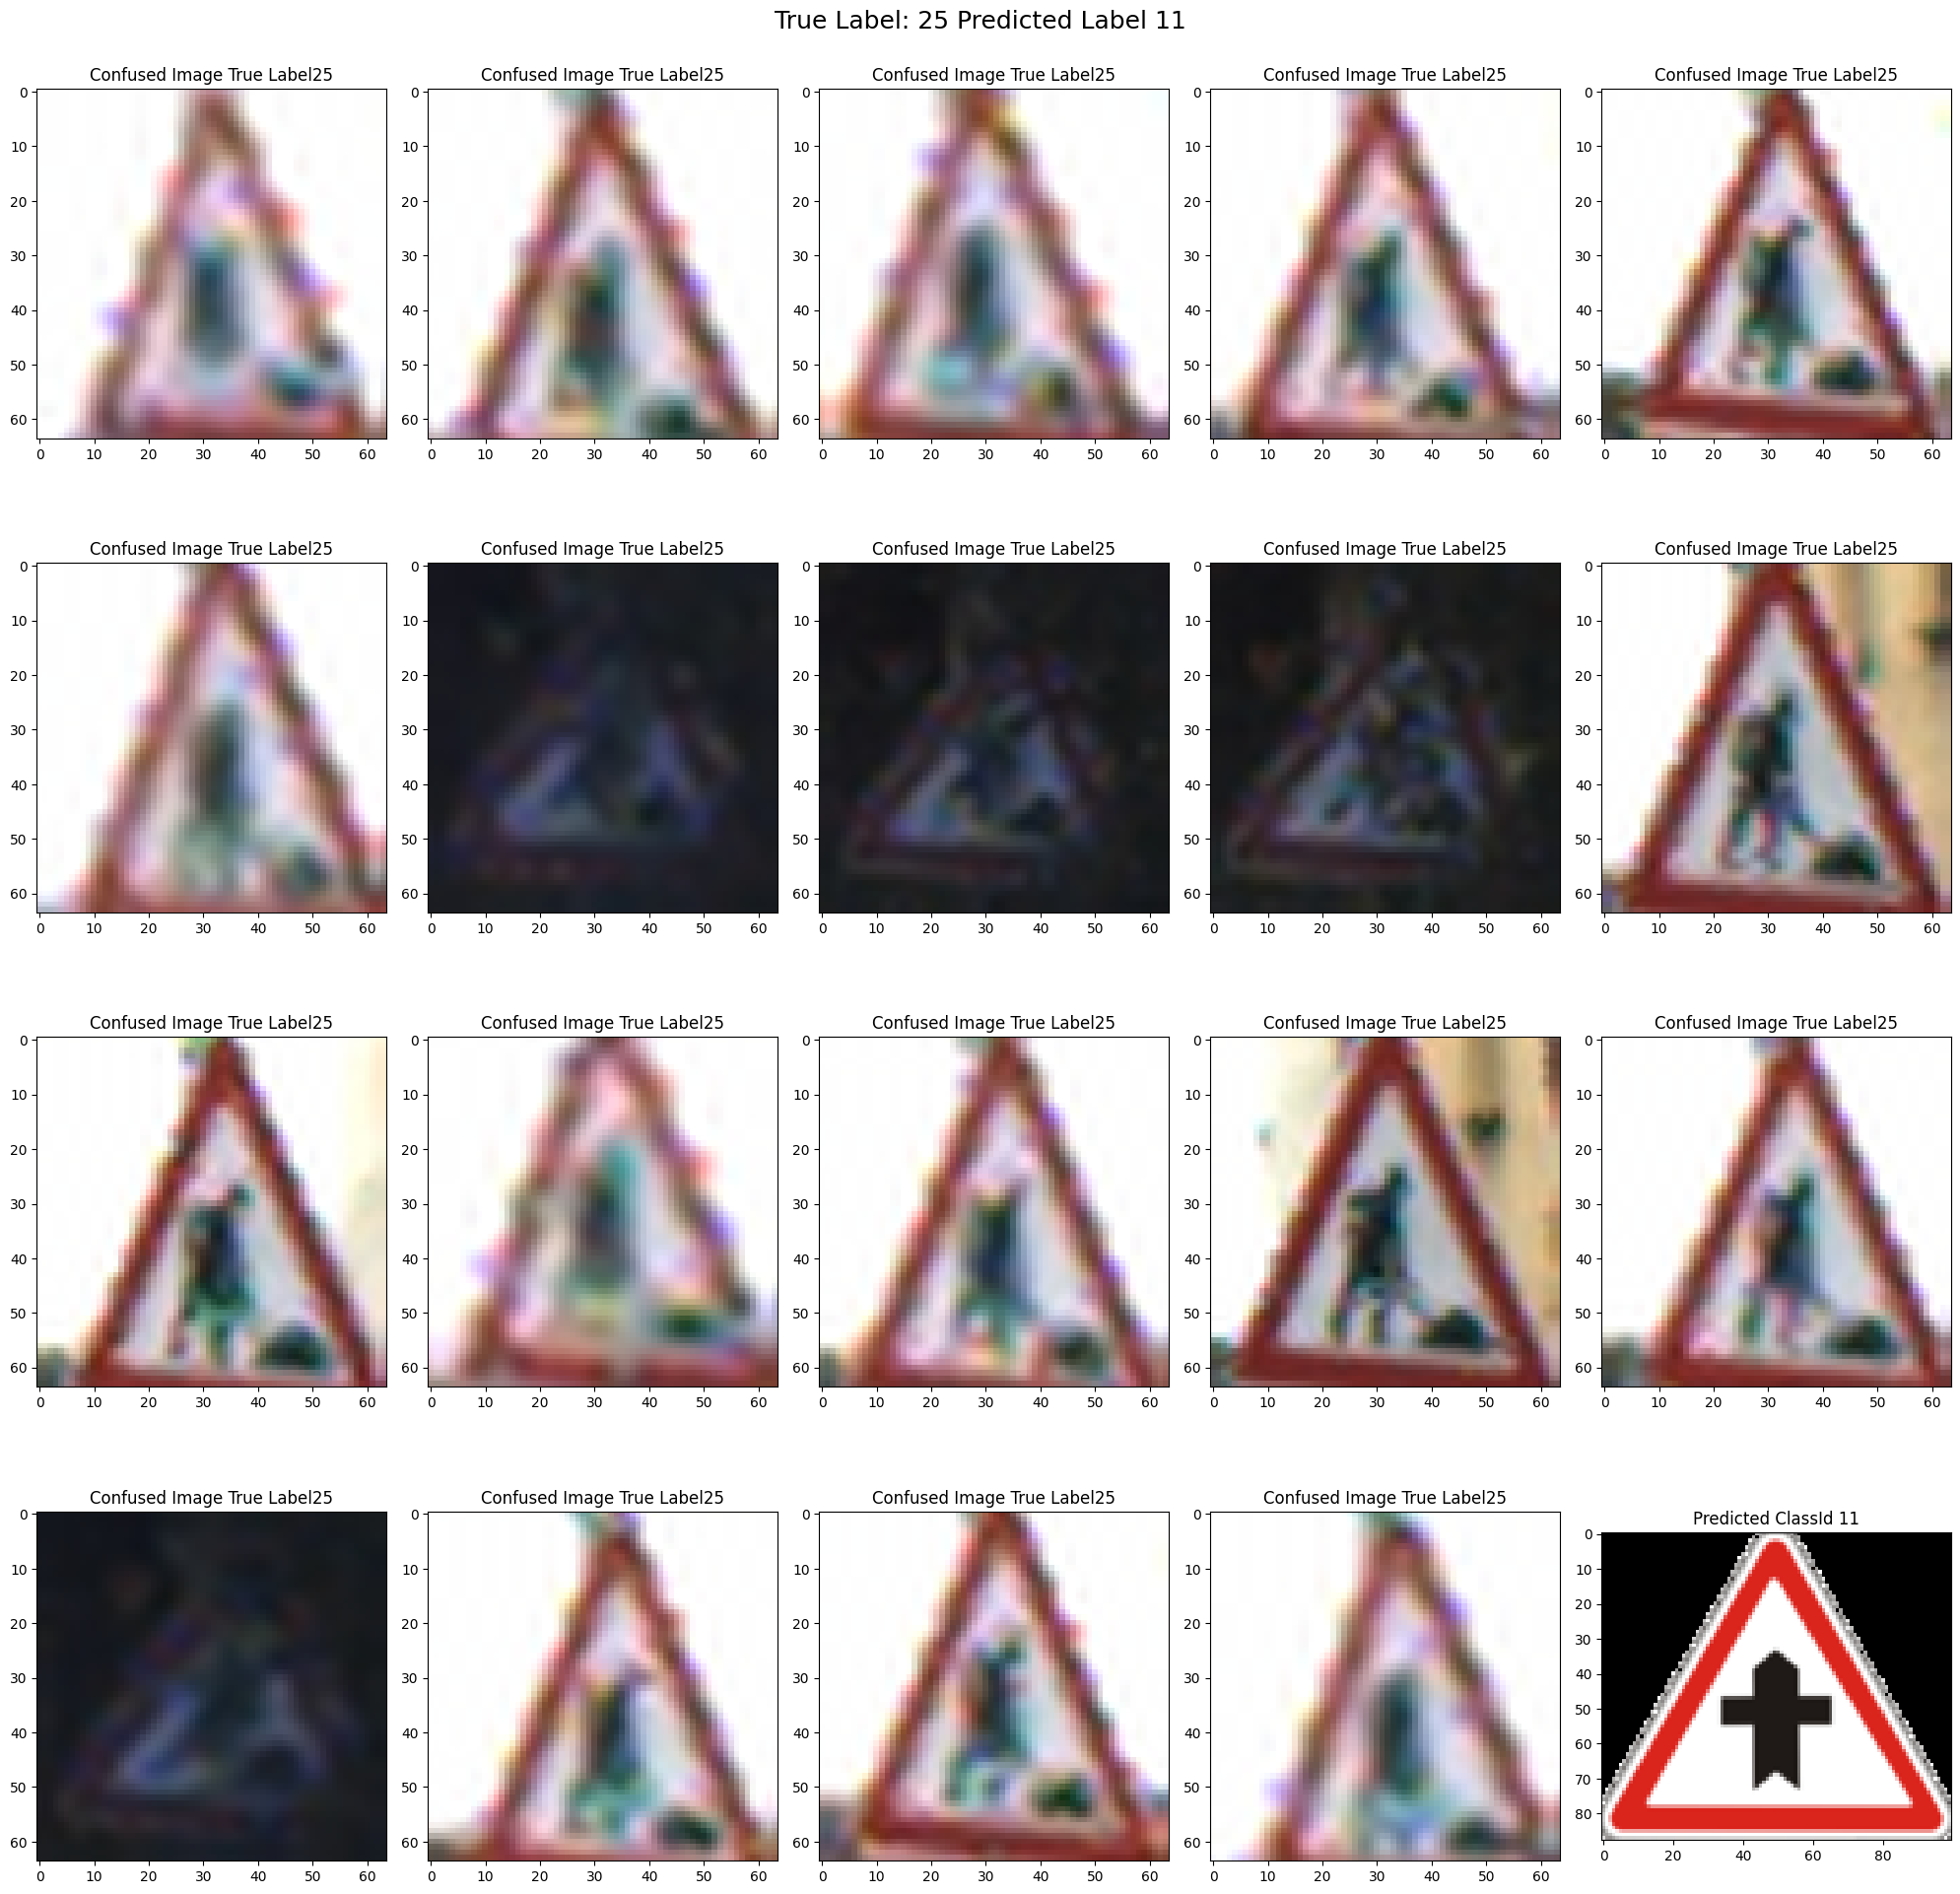

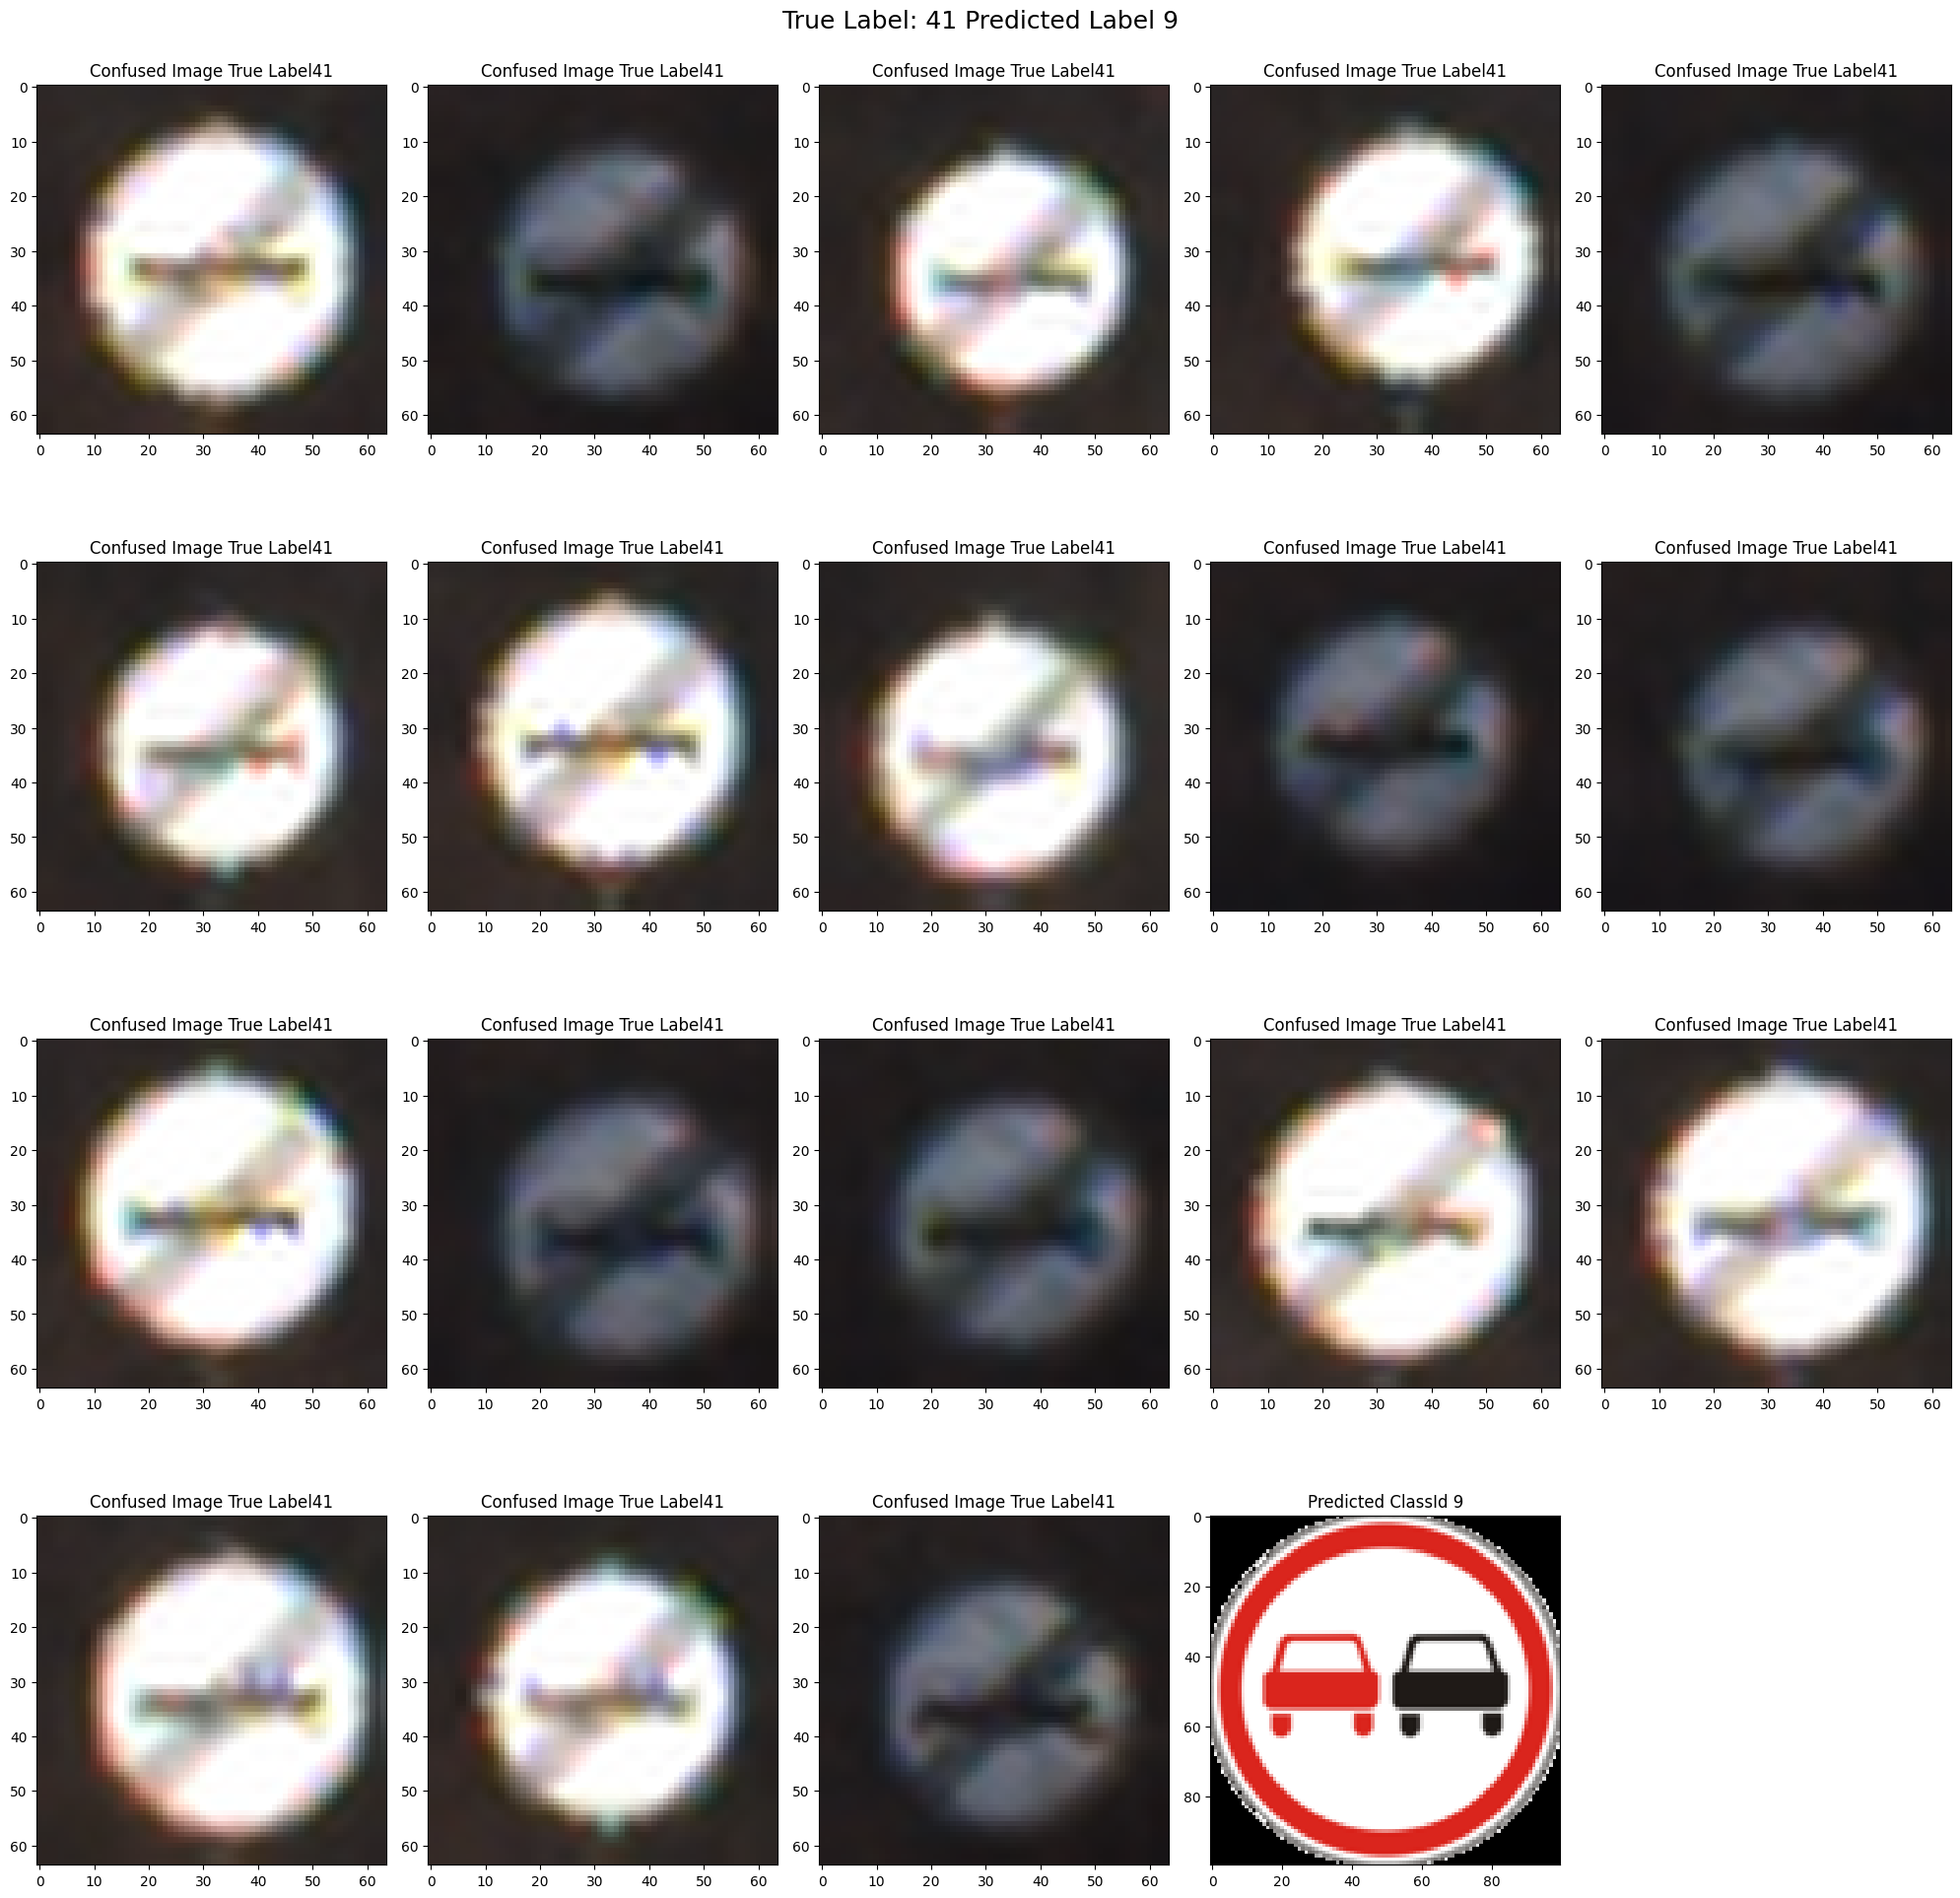

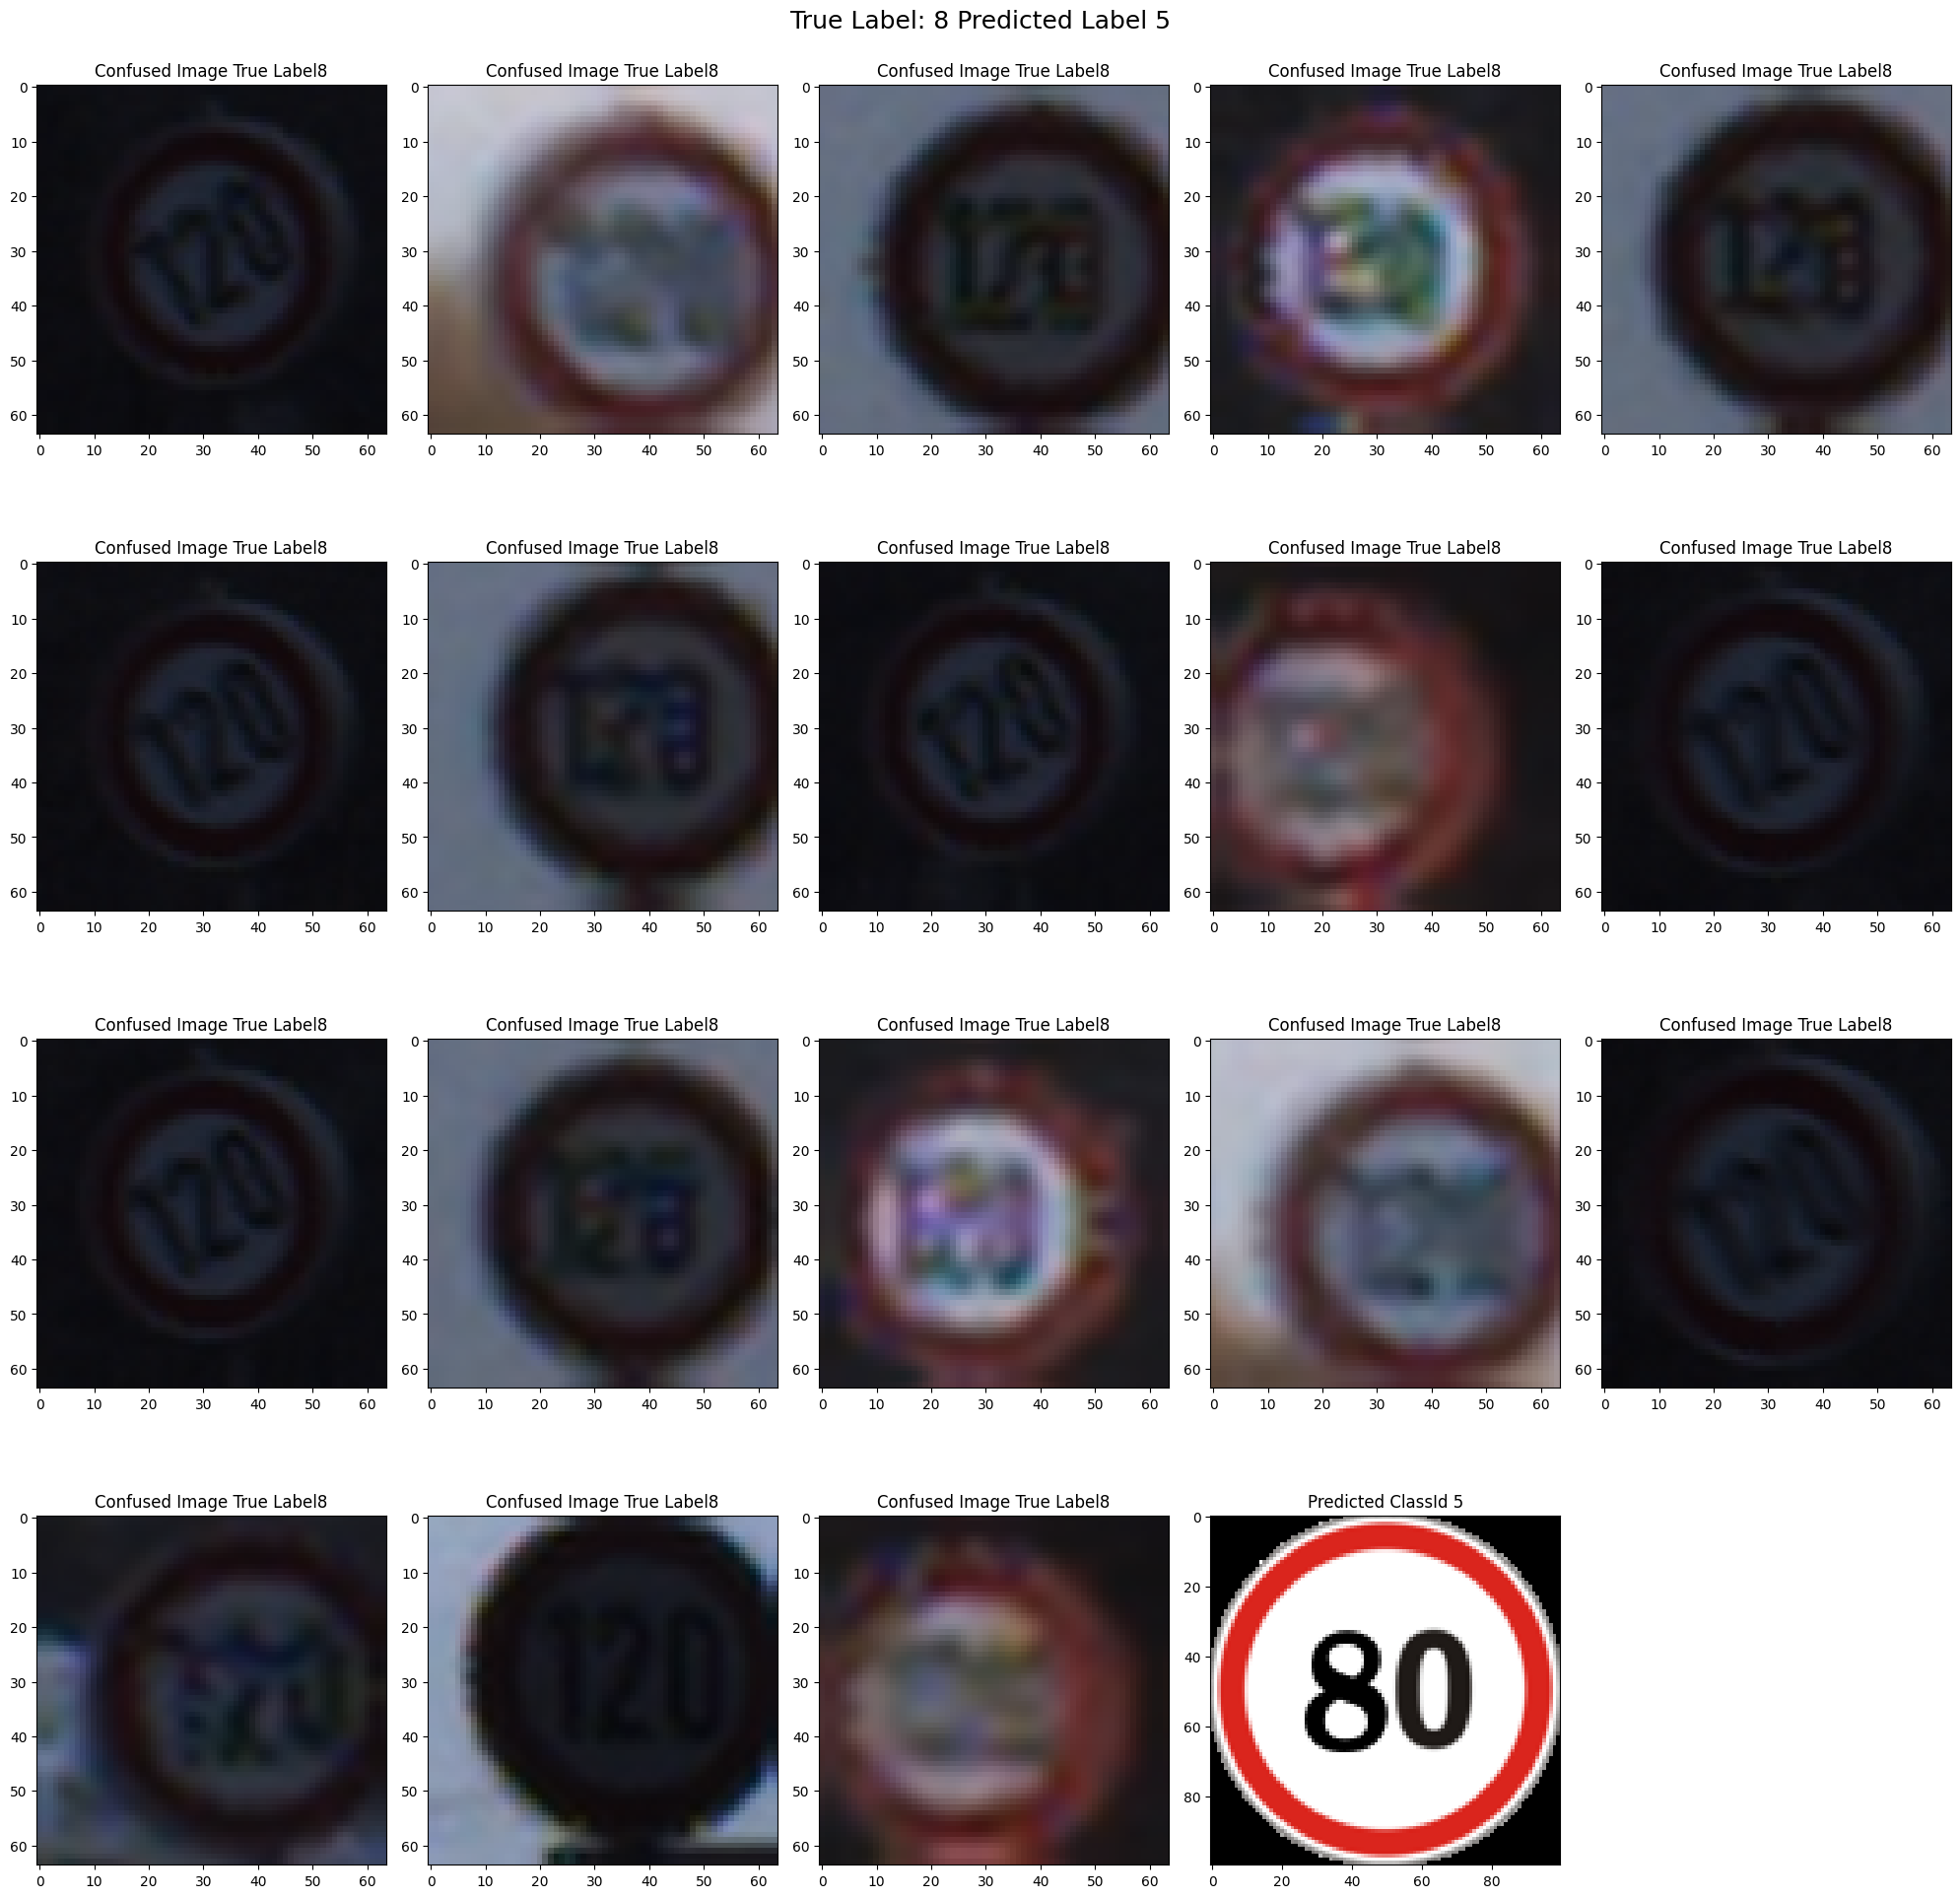

In [16]:
sorted_confused_index_dict = dict(
    sorted(confused_index_dict.items(), key=lambda x: len(x[1]), reverse=True)
)
for i, (labels, index_array) in enumerate(sorted_confused_index_dict.items()):
    images_by_confusion = []
    predicted_image = (
        np.load(
            BytesIO(meta_df.filter(meta_df["ClassId"] == labels[1])["Meta_Image"][0])
        )
        * 255.0
    ).astype(np.uint8)
    for current_image_index in index_array:
        images_by_confusion.append(
            ((np.load(BytesIO(test_df["Image"][current_image_index]))) * 255.0).astype(
                np.uint8
            )
        )

    n_row = num_rows = (len(images_by_confusion) + 1) // 5 + (
        (len(images_by_confusion) + 1) % 5 > 0
    )
    n_col = min((len(images_by_confusion) + 1), 5)
    fig = plt.figure(figsize=(20, 20))
    fig.suptitle(f"True Label: {labels[0]} Predicted Label {labels[1]}", fontsize=18)
    for j, c_image in enumerate(images_by_confusion):
        ax = fig.add_subplot(n_row, n_col, j + 1)
        ax.set_title("Confused Image True Label" + str(labels[0]))
        ax.imshow(c_image)
    ax = fig.add_subplot(n_row, n_col, j + 2)
    ax.set_title("Predicted ClassId " + str(labels[1]))
    ax.imshow(predicted_image)
    fig.tight_layout()
    plt.show()
    if i + 1 >= 10:
        break